# EDA on raw data (after collect)

This notebook main goal is to :
- Understand what is in the data : plot variables one by one, missing values, etc.
- See which data are correlated
- Removes useless variables : too much missing values, too correlated with other variables.
- See if data is biased on protected attributes

## Load packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# transparentai package : https://github.com/Nathanlauga/transparentai
from transparentai.datasets import StructuredDataset
import transparentai.explore as explore

In [2]:
PROJECT_PATH = '..'

## Load data informations

In [3]:
df_details = pd.read_csv(f'{PROJECT_PATH}/01_collect/columns_informations.csv')

In [4]:
df_details

dataset           column   dtype  is_protected      new_name  \
0    adult              age   int64             1           NaN   
1    adult        workclass  object             0           NaN   
2    adult           fnlwgt   int64             0  final_weight   
3    adult        education  object             0           NaN   
4    adult  educational-num   int64             0           NaN   
5    adult   marital-status  object             1           NaN   
6    adult       occupation  object             0           NaN   
7    adult     relationship  object             0           NaN   
8    adult             race  object             1           NaN   
9    adult           gender  object             1           NaN   
10   adult     capital-gain   int64             0           NaN   
11   adult     capital-loss   int64             0           NaN   
12   adult   hours-per-week   int64             0           NaN   
13   adult   native-country  object             1           NaN   
14   adult           income  object             0           NaN   

                                          description  
0                                   Age of the person  
1              Workclass of the person (e.g. Private)  
2   final weight, which is the number of units in ...  
3                                     Education level  
4                  Education level (numerical format)  
5                                      Marital status  
6                                    Field occupation  
7                                Current relationship  
8                                           Ethnicity  
9                                      Female or Male  
10                                    Gain of capital  
11                                    Loss of capital  
12              number of working hours during a week  
13                                     Native country  
14                       Target : income > 50K or not

## Load data using data informations

In [5]:
dfs = {}
datasets = df_details['dataset'].unique()

for dataset in datasets:
    dataset_detail = df_details[df_details['dataset'] == dataset]

    dtypes, columns = dataset_detail['dtype'], dataset_detail['column']
    dtypes = pd.Series(dtypes.values,index=columns)

    parse_dates = list()
    for var, dtype in dtypes.iteritems():
        if 'datetime' in dtype:
            parse_dates.append(var)

    dtypes = dtypes.str.replace(r'datetime.*','str')

    dfs[dataset] = pd.read_csv(f'{PROJECT_PATH}/_data/{dataset}.csv',
                               dtype=dtypes.to_dict(),
                               parse_dates=parse_dates
                              )

    columns = np.where(dataset_detail['new_name'].isna(), columns, dataset_detail['new_name'])
    dfs[dataset].columns = columns

## Display shape & head

In [6]:
for dataset in dfs:
    display(Markdown(f'#### {dataset}, {dfs[dataset].shape}'))
    display(dfs[dataset].head())

#### adult, (48842, 15)

age  workclass  final_weight     education  educational-num  \
0   25    Private        226802          11th                7   
1   38    Private         89814       HS-grad                9   
2   28  Local-gov        336951    Assoc-acdm               12   
3   44    Private        160323  Some-college               10   
4   18          ?        103497  Some-college               10   

       marital-status         occupation relationship   race  gender  \
0       Never-married  Machine-op-inspct    Own-child  Black    Male   
1  Married-civ-spouse    Farming-fishing      Husband  White    Male   
2  Married-civ-spouse    Protective-serv      Husband  White    Male   
3  Married-civ-spouse  Machine-op-inspct      Husband  Black    Male   
4       Never-married                  ?    Own-child  White  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0             0             0              40  United-States  <=50K  
1             0             0              50  United-States  <=50K  
2             0             0              40  United-States   >50K  
3          7688             0              40  United-States   >50K  
4             0             0              30  United-States  <=50K

## Set datasets into differents variables

Here we just have one dataset `adult`, but if in the next versions we had some others datasets it's important to set them into distinct variables. 

In [7]:
adult = dfs['adult']
del dfs

In [8]:
adult['age category'] = np.where(adult['age'] < 26, 'Young',
                                 np.where(adult['age'] < 61, 'Adult','Elder'))

In [9]:
privileged_values = {
    'age category': ['Adult'],
    'marital-status': ['Married-civ-spouse','Married-AF-spouse'],
    'race': ['White'],
    'gender': ['Male']
}
dataset = StructuredDataset(df=adult,
                           privileged_values=privileged_values,
                           target='income'
                          )

In [12]:
dataset.plot_missing_values()

TypeError: plot_missing_values() got an unexpected keyword argument 'df'

In [20]:
# Understand my data
dataset.plot_missing_values()

dataset.plot_variables()
dataset.plot_num_variable(var='var')
dataset.plot_cat_variable(var='var')
dataset.plot_datetime_variable(var='var')

dataset.plot_variables_scatter()
dataset.plot_scatter_two_variables(var1='var1', var2='var2')

dataset.plot_variables_boxplot()
dataset.plot_boxplot_two_variables(cat_var='cat_var', num_var='num_var')

dataset.plot_correlations()

# show bias
dataset.get_bias_metrics(attr='attr')

dataset.plot_bias(attr='attr', target_value='1')
dataset.display_insight(attr='attr', target_value='1')

# Split dataset
X_train, X_test, y_train, y_test = dataset.split_train_test()
X, y = dataset.get_train()
X, y = dataset.get_test()

## Analyse : missing values

In [8]:
help(explore.show_missing_values)

Help on function show_missing_values in module transparentai.explore.explore:

show_missing_values(df)
    Show a bar plot that display percentage of missing values on columns that have some.
    If no missing value then it use `display` & `Markdown` functions to indicate it.
    
    Parameters
    ----------
    df: pd.DataFrame
        Dataframe to inspect



In [9]:
display(Markdown('#### Missing values for adult dataset'))
explore.show_missing_values(adult)

#### Missing values for adult dataset

No missing value.

## Analyse : plot each variable

### Using MLHelper

In [10]:
from transparentai.utils import remove_var_with_one_value
adult = remove_var_with_one_value(adult)

In [11]:
help(explore.show_df_vars)

Help on function show_df_vars in module transparentai.explore.explore:

show_df_vars(df, target=None)
    Show all variables with graphics to understand each variable.
    If target is set, complement visuals will be added to take a look on the
    influence that a variable can have on target
    
    Data type handle : categorical, numerical, datetime
    
    Parameters
    ----------
    df: pd.DataFrame
        Dataframe to inspect
    target: str (optional)
        Target column for classifier



### Numerical variables

**age :** 0 nulls, 74 unique vals, most common: {36: 1348, 35: 1337}

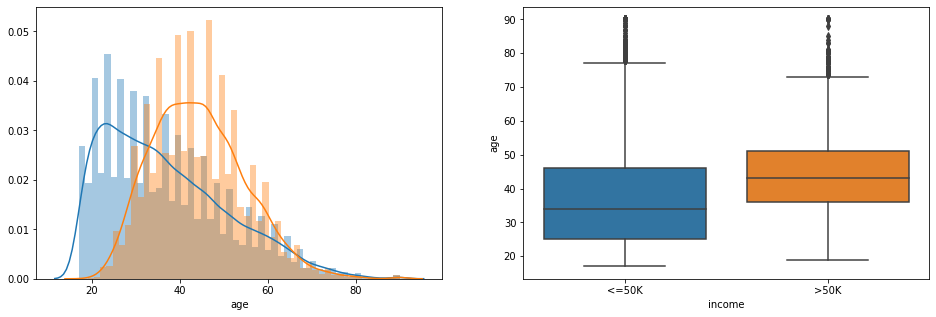

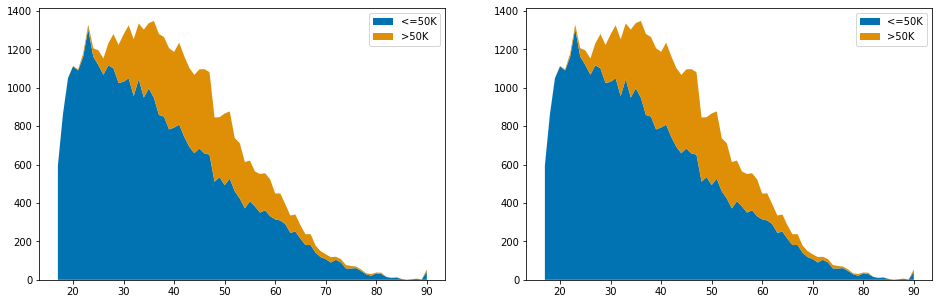

**final_weight :** 0 nulls, 28523 unique vals, most common: {203488: 21, 190290: 19}

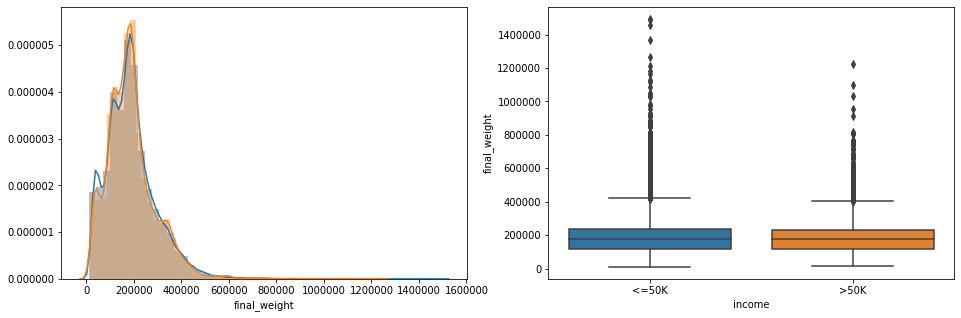

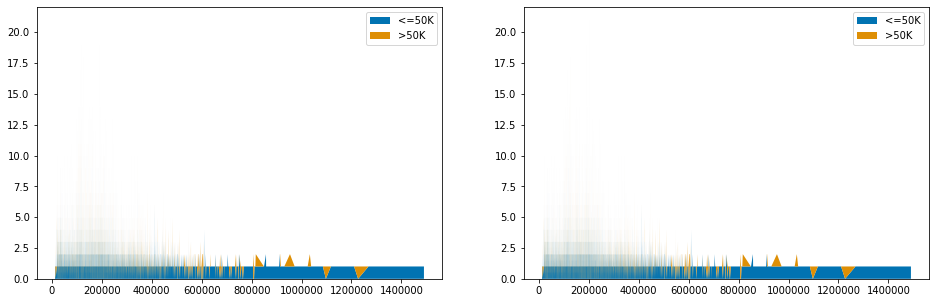

**educational-num :** 0 nulls, 16 unique vals, most common: {9: 15784, 10: 10878}

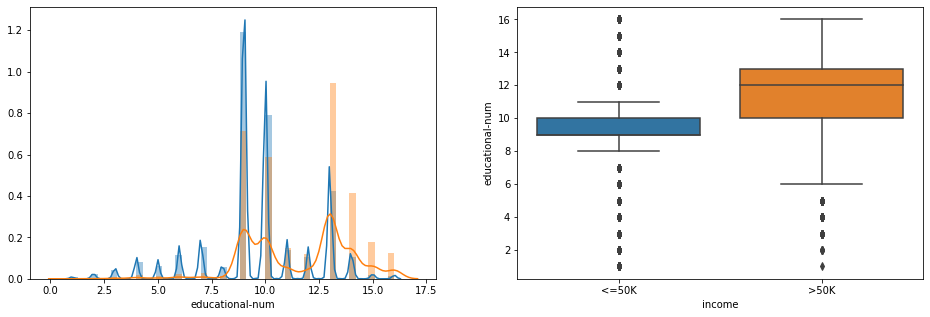

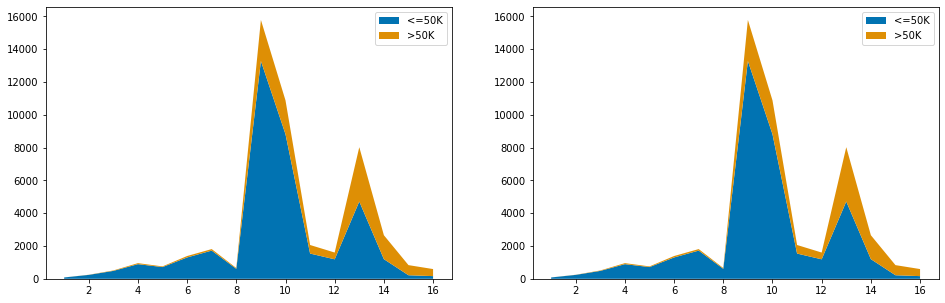

**capital-gain :** 0 nulls, 123 unique vals, most common: {0: 44807, 15024: 513}

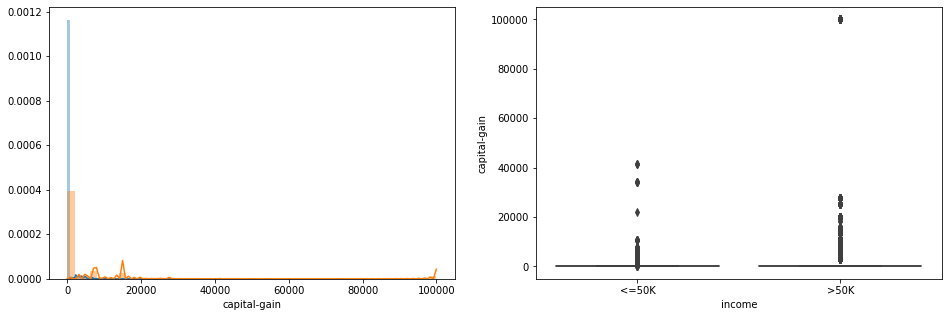

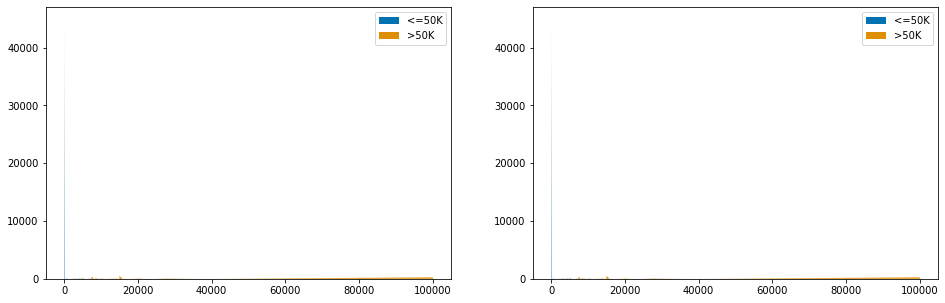

**capital-loss :** 0 nulls, 99 unique vals, most common: {0: 46560, 1902: 304}

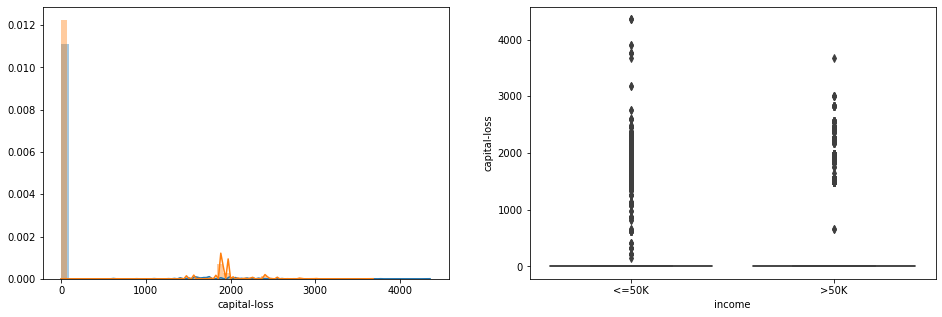

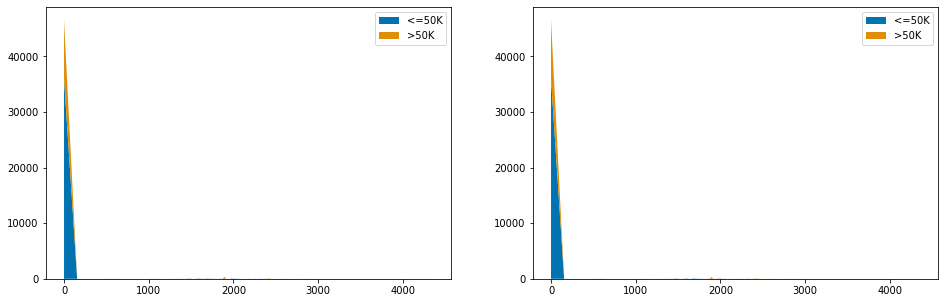

**hours-per-week :** 0 nulls, 96 unique vals, most common: {40: 22803, 50: 4246}

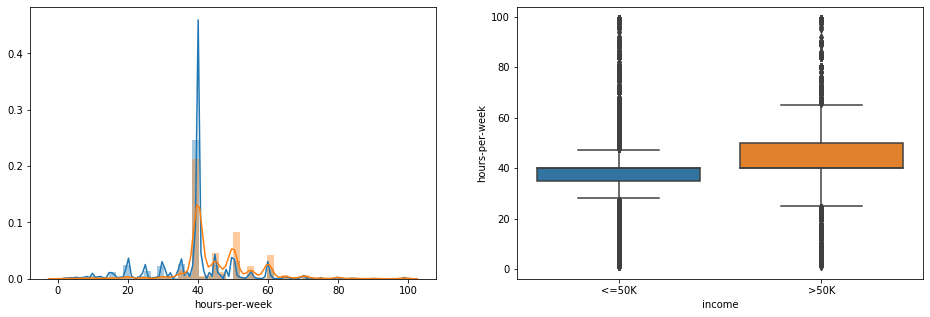

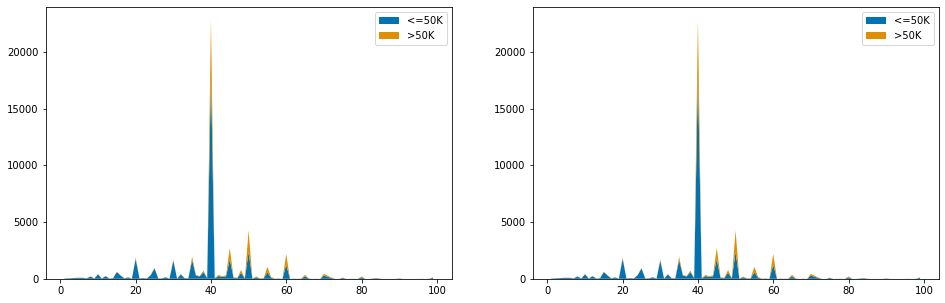

### Categorical variables

**workclass :** 0 nulls, 9 unique vals, most common: {'Private': 33906, 'Self-emp-not-inc': 3862}

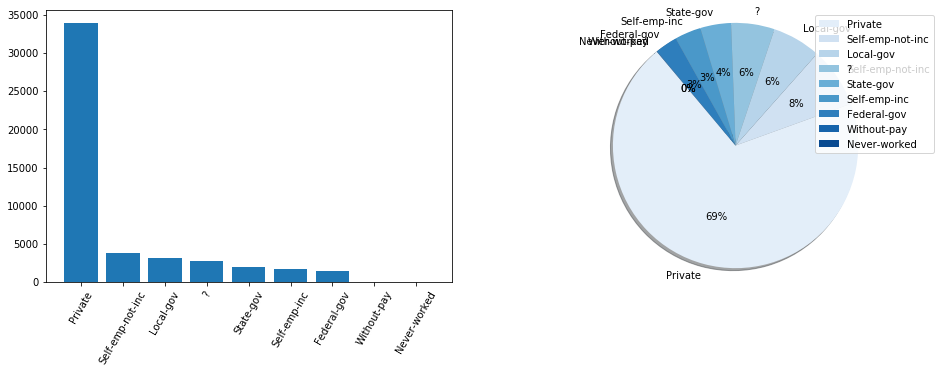

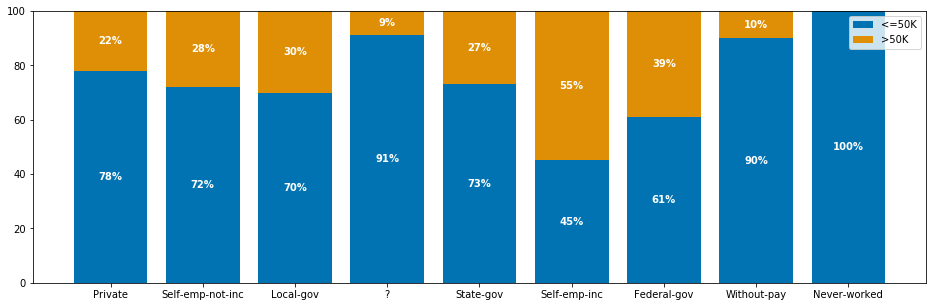

**education :** 0 nulls, 16 unique vals, most common: {'HS-grad': 15784, 'Some-college': 10878}

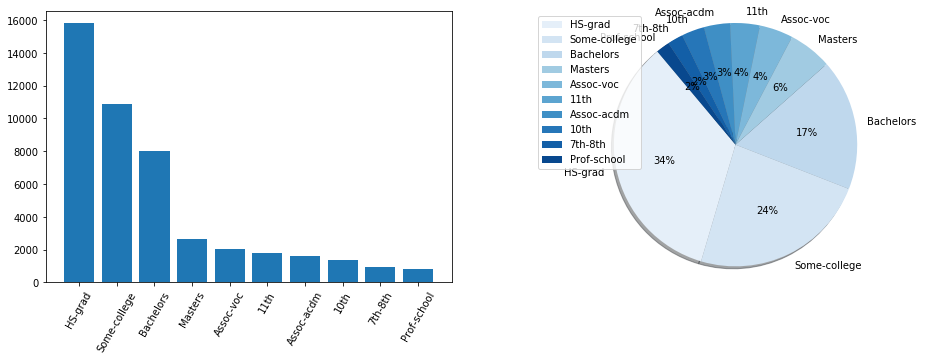

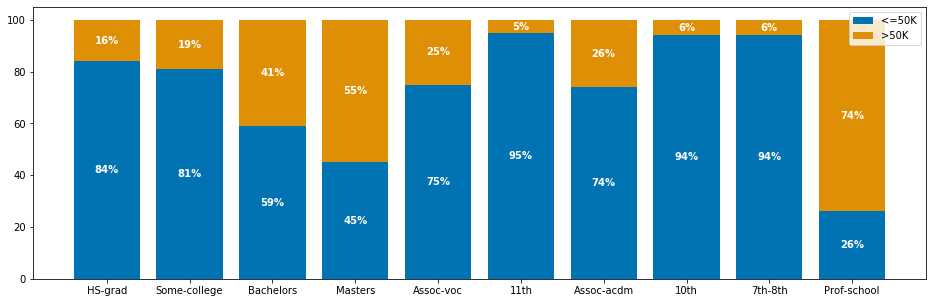

**marital-status :** 0 nulls, 7 unique vals, most common: {'Married-civ-spouse': 22379, 'Never-married': 16117}

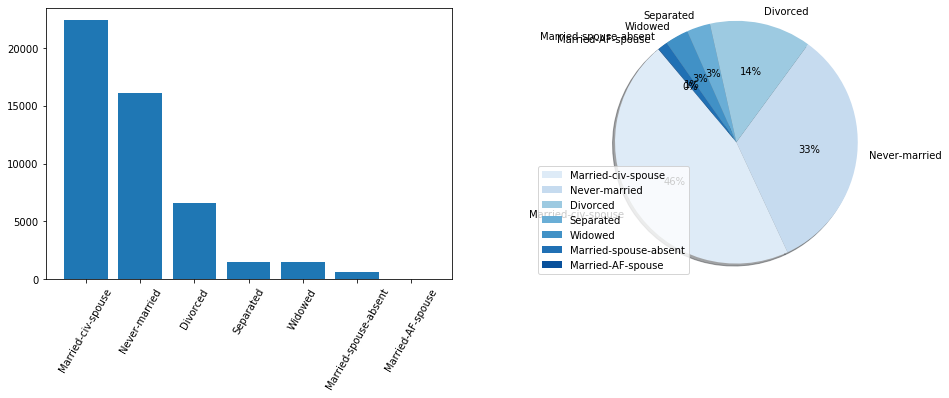

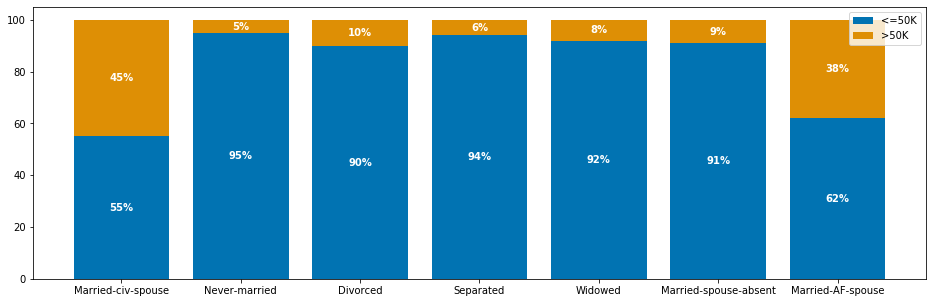

**occupation :** 0 nulls, 15 unique vals, most common: {'Prof-specialty': 6172, 'Craft-repair': 6112}

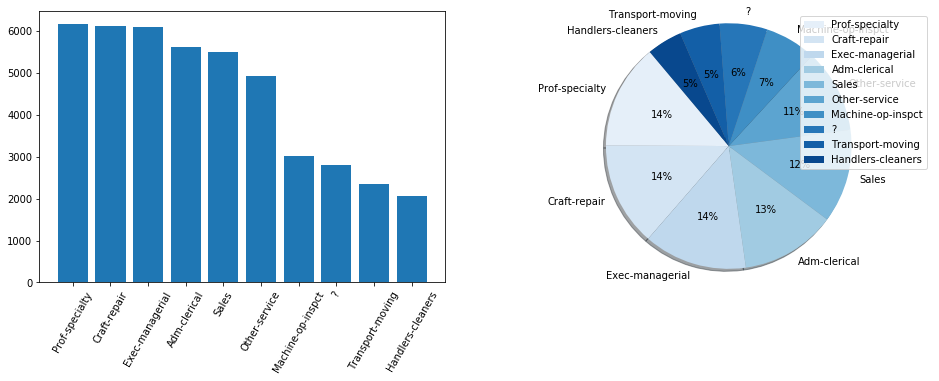

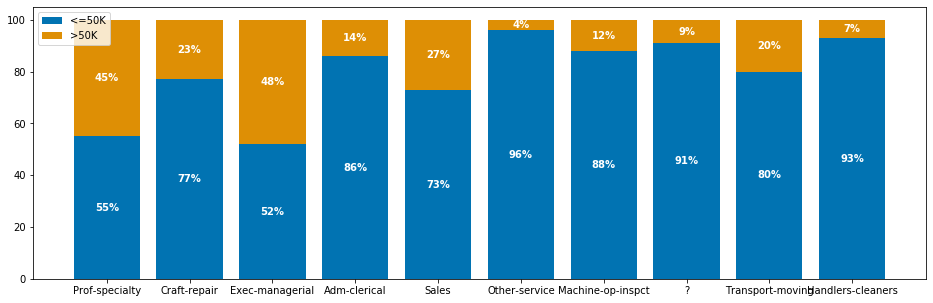

**relationship :** 0 nulls, 6 unique vals, most common: {'Husband': 19716, 'Not-in-family': 12583}

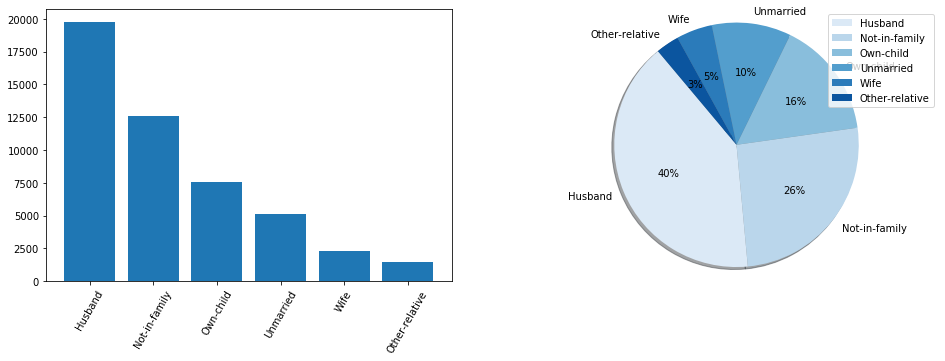

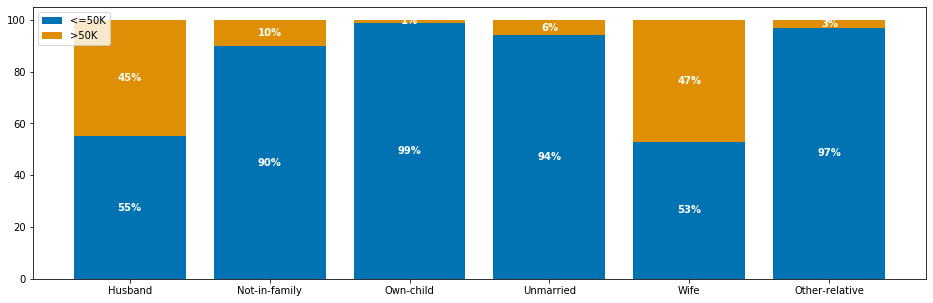

**race :** 0 nulls, 5 unique vals, most common: {'White': 41762, 'Black': 4685}

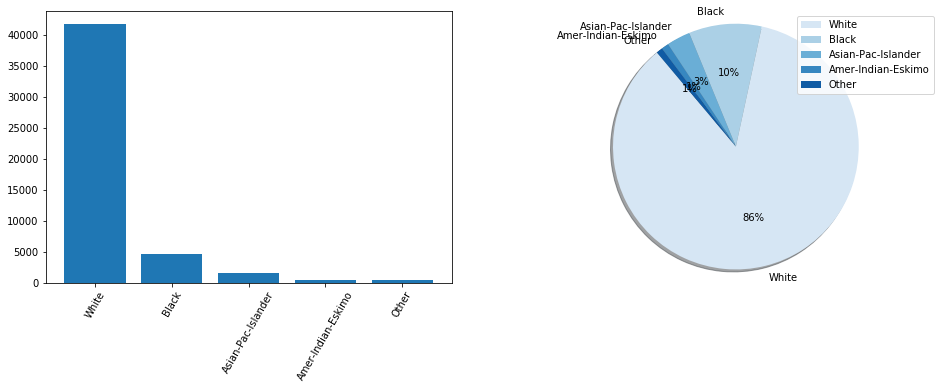

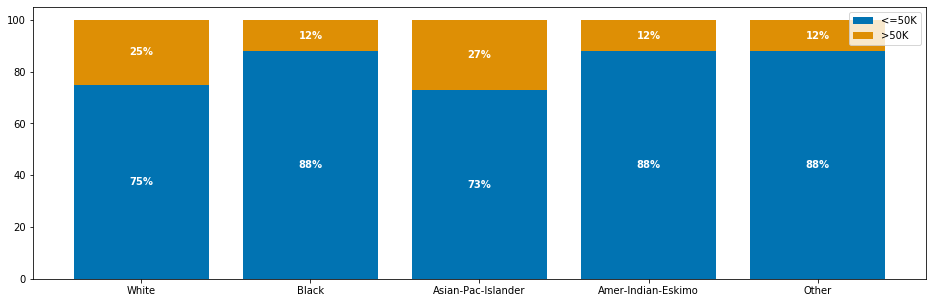

**gender :** 0 nulls, 2 unique vals, most common: {'Male': 32650, 'Female': 16192}

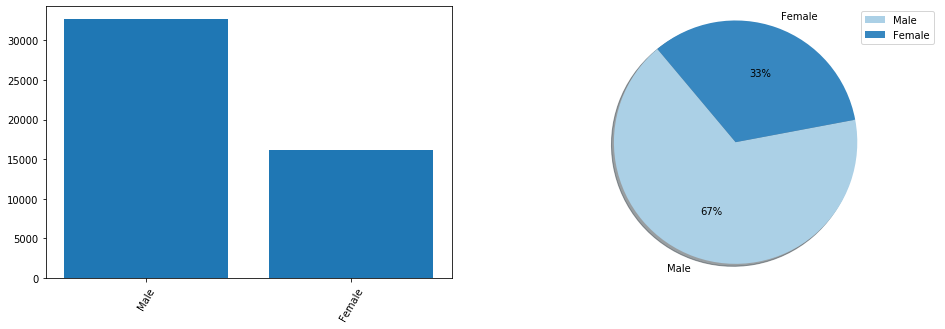

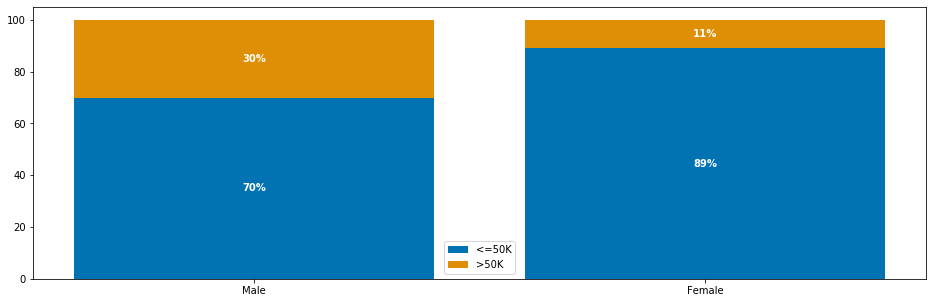

**native-country :** 0 nulls, 42 unique vals, most common: {'United-States': 43832, 'Mexico': 951}

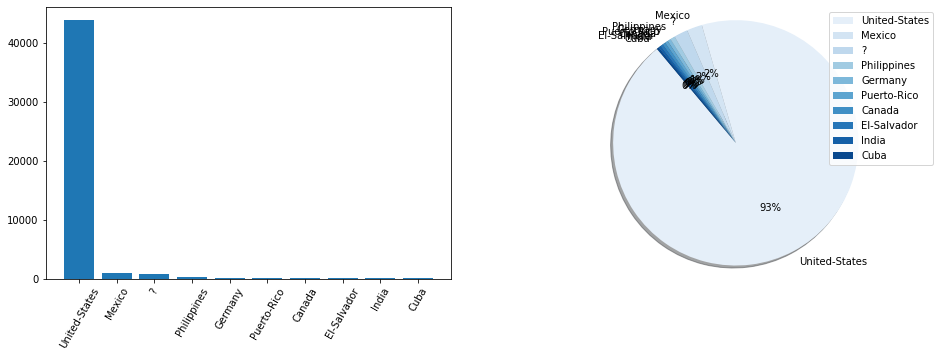

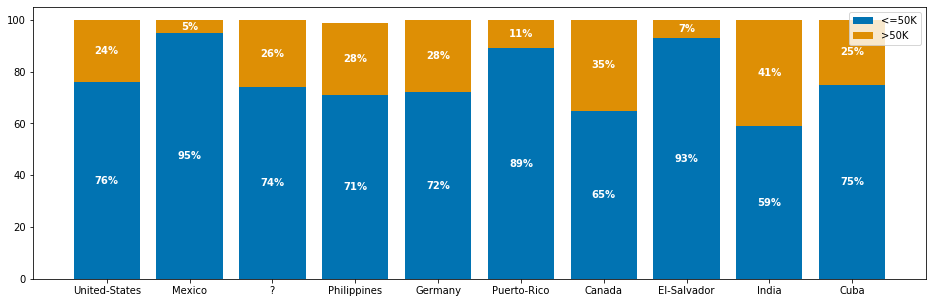

**income :** 0 nulls, 2 unique vals, most common: {'<=50K': 37155, '>50K': 11687}

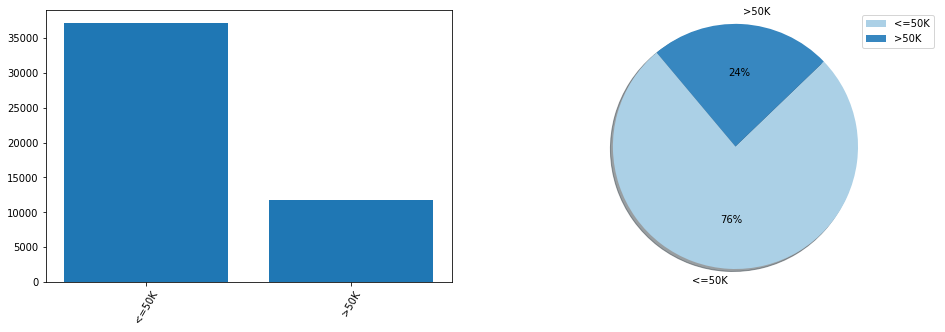

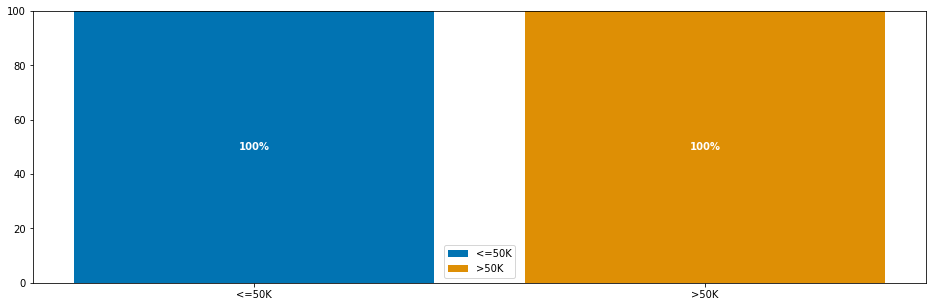

### Datetime variables

In [12]:
explore.show_df_vars(df=adult, target='income')

In [13]:
help(explore.show_df_numerical_relations)

Help on function show_df_numerical_relations in module transparentai.explore.explore:

show_df_numerical_relations(df, target=None)
    Show all numerical variables 2 by 2 with graphics understand their relation.
    If target is set, separate dataset for each target value.
    
    Parameters
    ----------
    df: pd.DataFrame
        Dataframe to inspect
    target: str (optional)
        Target column for classifier



Joint plot for **capital-loss** & **educational-num**

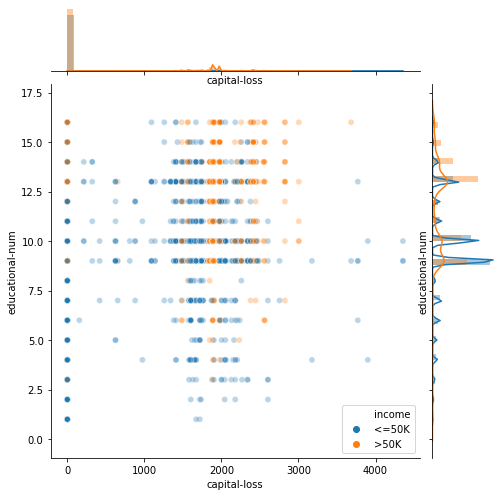

Joint plot for **educational-num** & **final_weight**

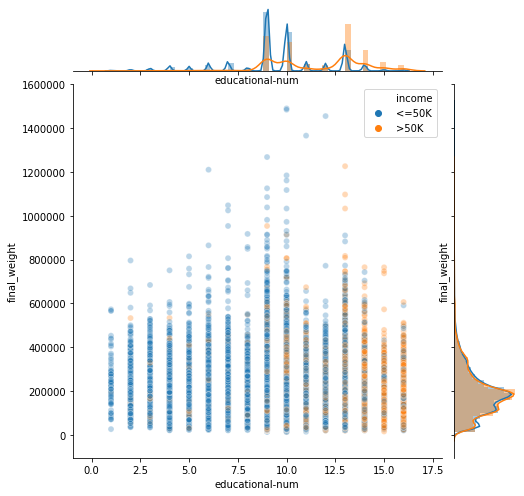

Joint plot for **final_weight** & **hours-per-week**

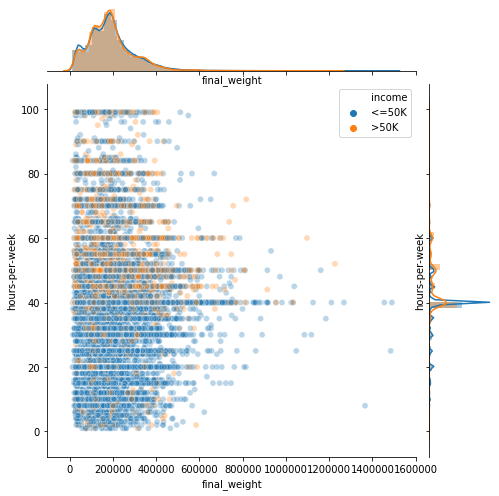

Joint plot for **capital-loss** & **final_weight**

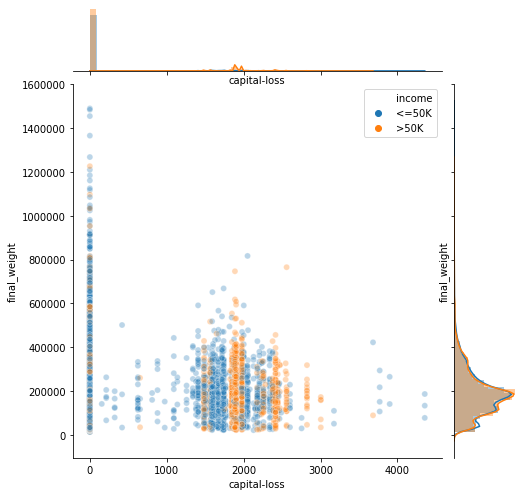

Joint plot for **age** & **capital-loss**

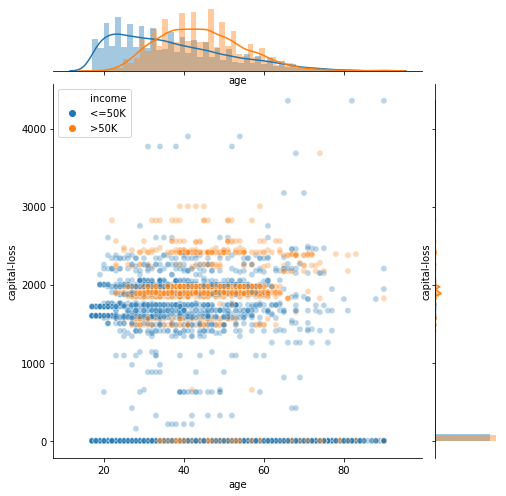

Joint plot for **age** & **final_weight**

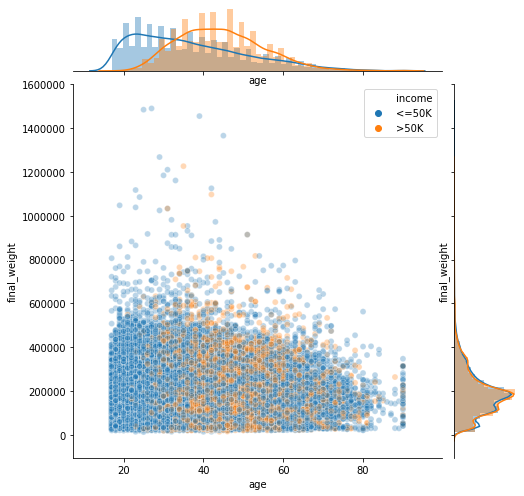

Joint plot for **capital-gain** & **hours-per-week**

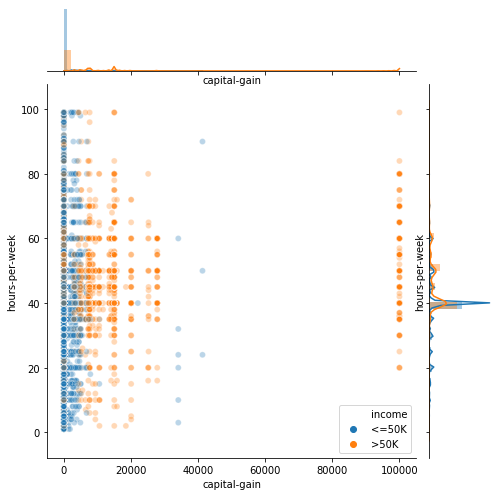

Joint plot for **capital-gain** & **capital-loss**

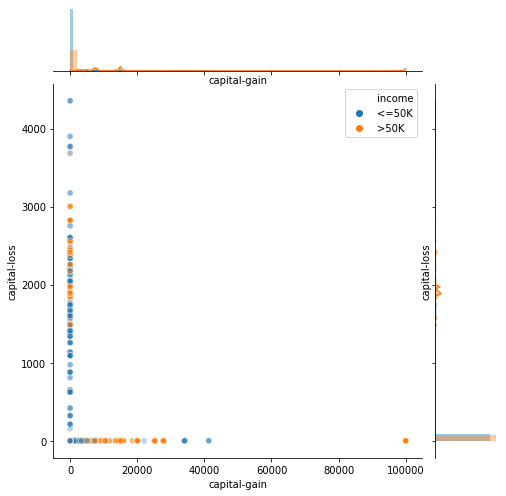

Joint plot for **age** & **educational-num**

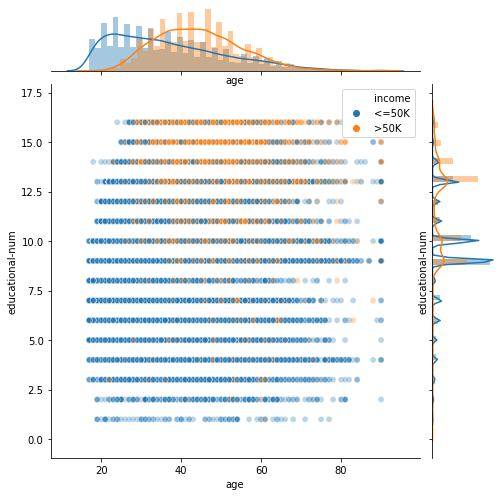

Joint plot for **age** & **hours-per-week**

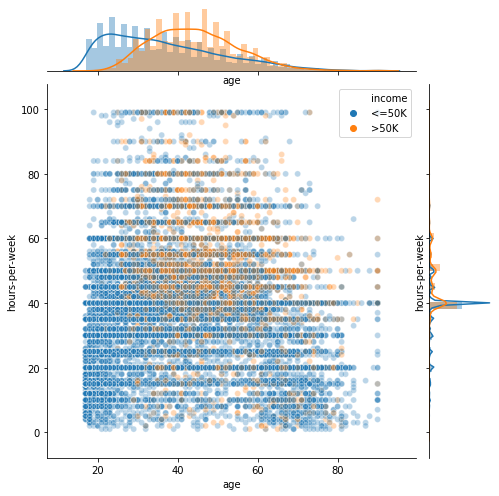

Joint plot for **capital-loss** & **hours-per-week**

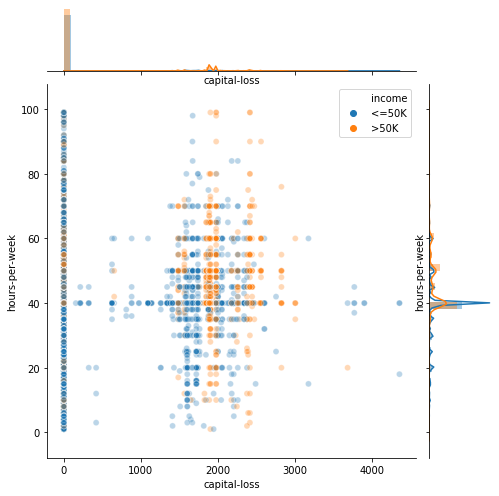

Joint plot for **capital-gain** & **final_weight**

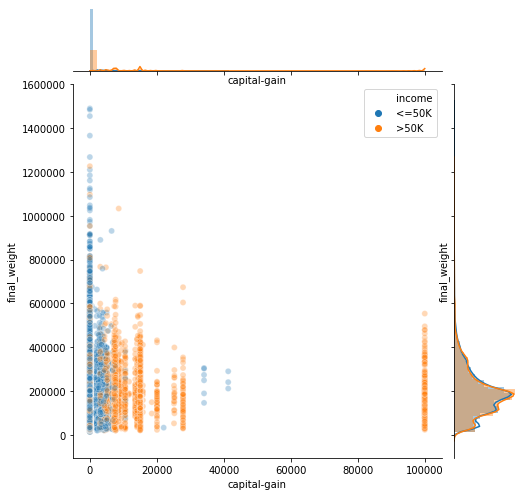

Joint plot for **capital-gain** & **educational-num**

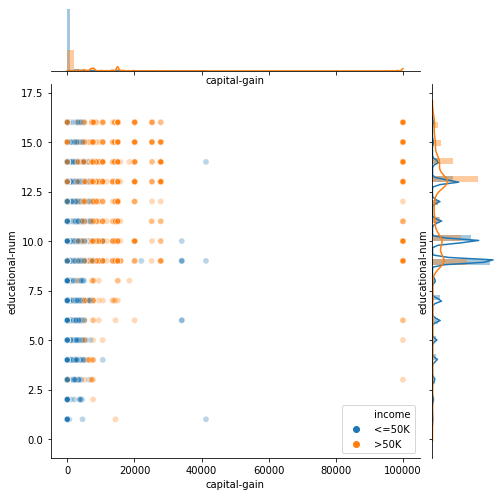

Joint plot for **educational-num** & **hours-per-week**

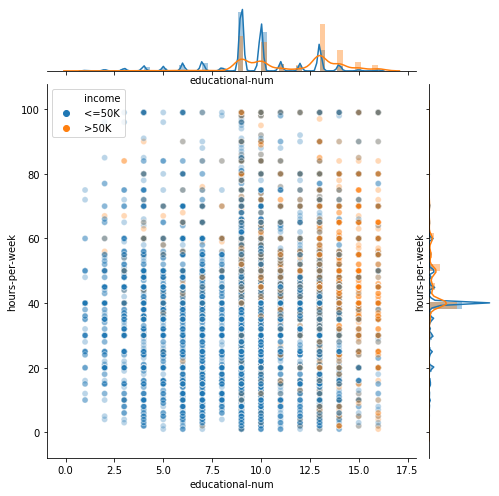

Joint plot for **age** & **capital-gain**

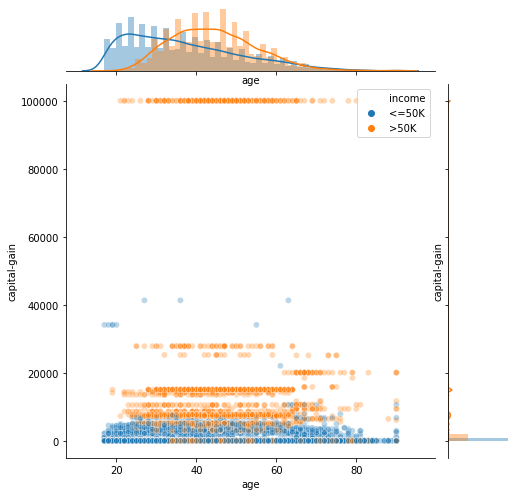

In [14]:
explore.show_df_numerical_relations(df=adult, target='income')

In [15]:
help(explore.show_df_num_cat_relations)

Help on function show_df_num_cat_relations in module transparentai.explore.explore:

show_df_num_cat_relations(df, target=None)
    Show boxplots for each pair of categorical and numerical variables
    If target is set, separate dataset for each target value.
    
    Parameters
    ----------
    df: pd.DataFrame
        Dataframe to inspect
    target: str (optional)
        Target column for classifier



Box plot for **workclass** & **age**

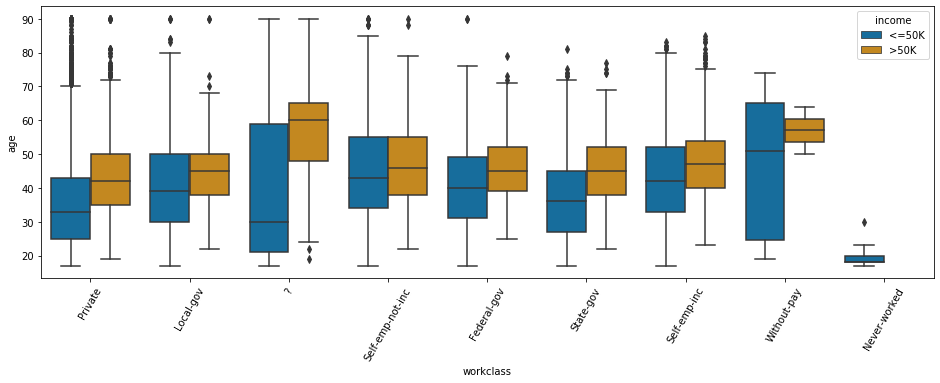

Box plot for **education** & **age**

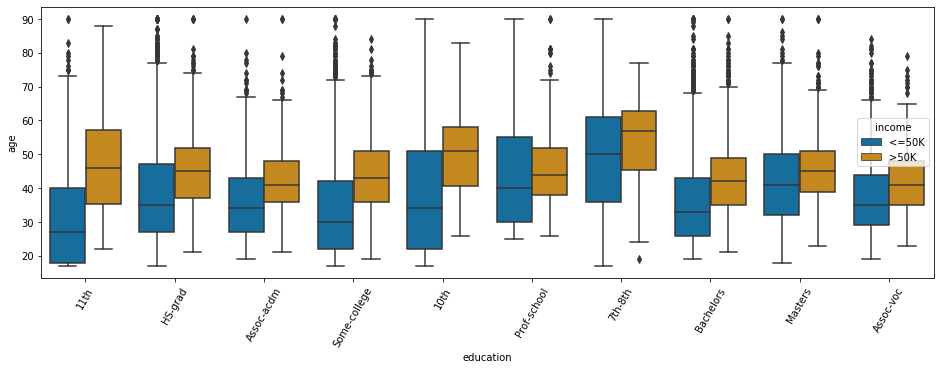

Box plot for **marital-status** & **age**

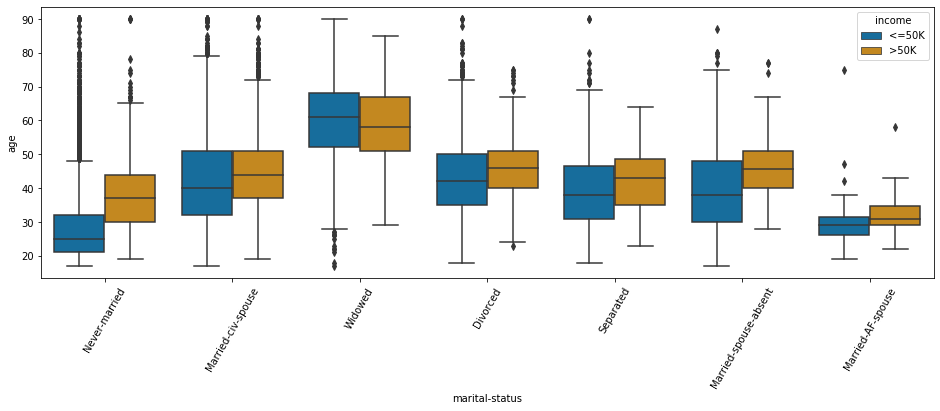

Box plot for **occupation** & **age**

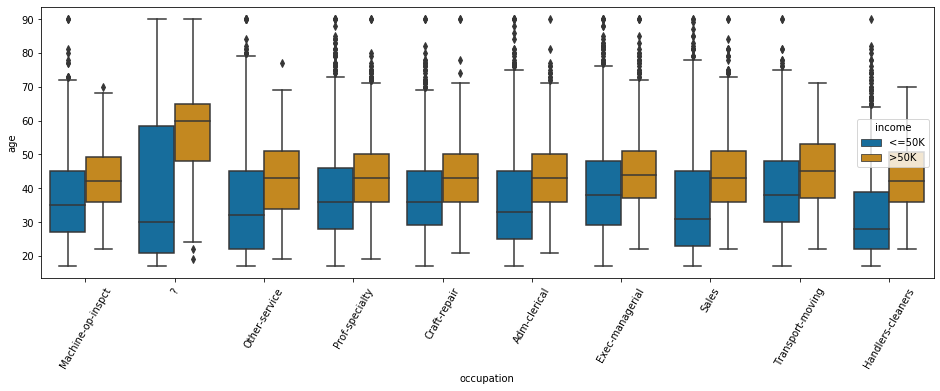

Box plot for **relationship** & **age**

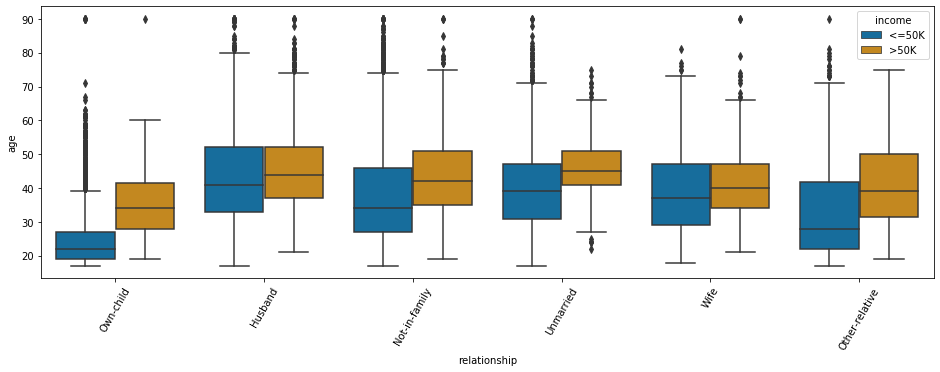

Box plot for **race** & **age**

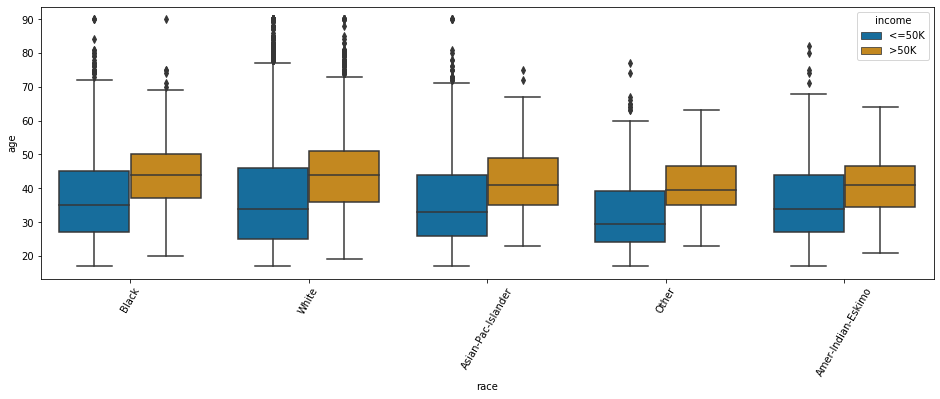

Box plot for **gender** & **age**

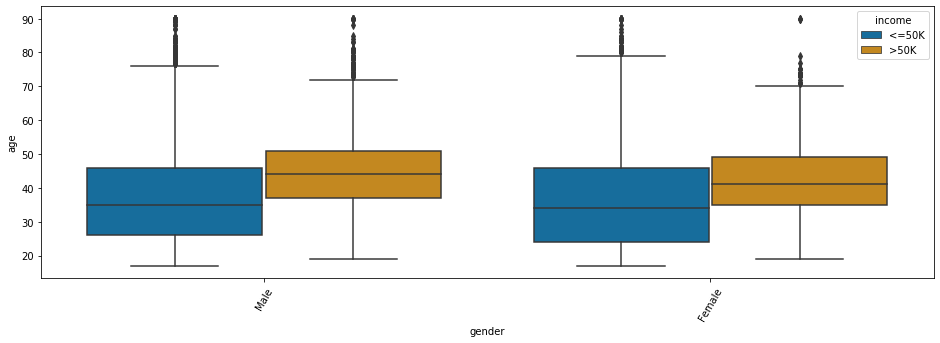

Box plot for **native-country** & **age**

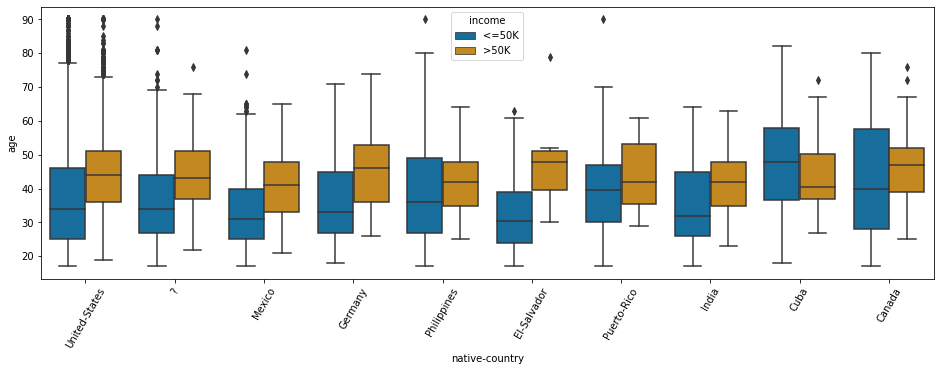

Box plot for **workclass** & **final_weight**

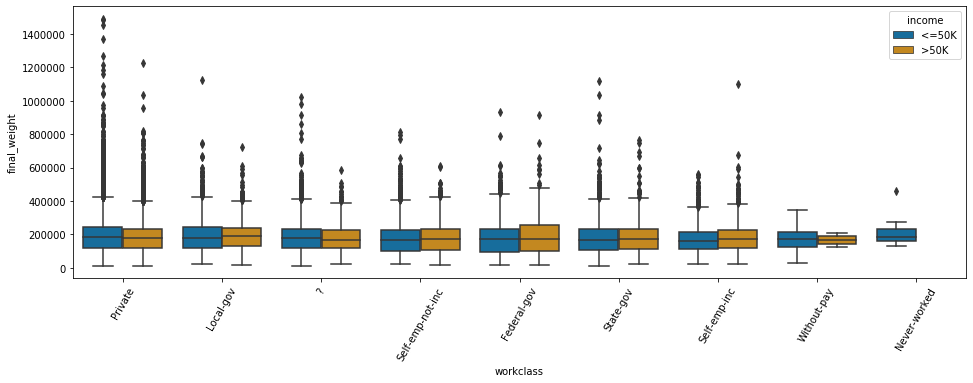

Box plot for **education** & **final_weight**

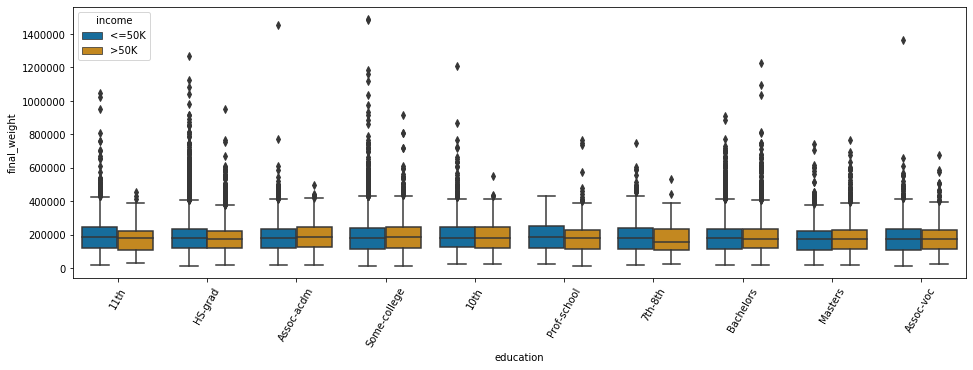

Box plot for **marital-status** & **final_weight**

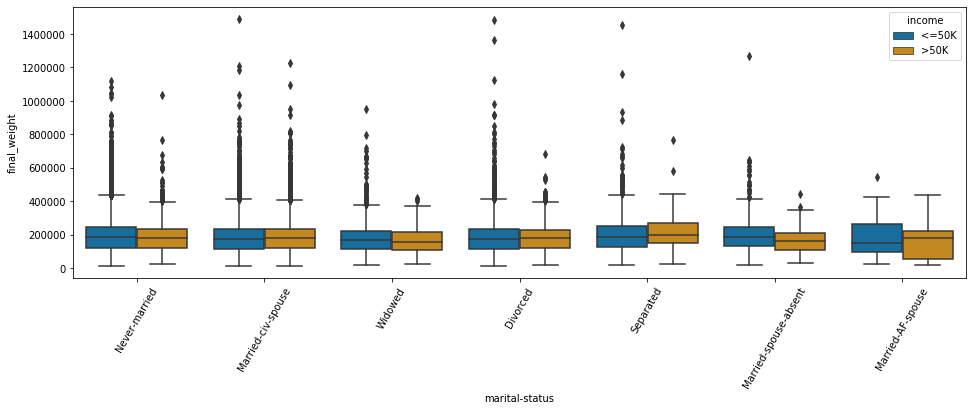

Box plot for **occupation** & **final_weight**

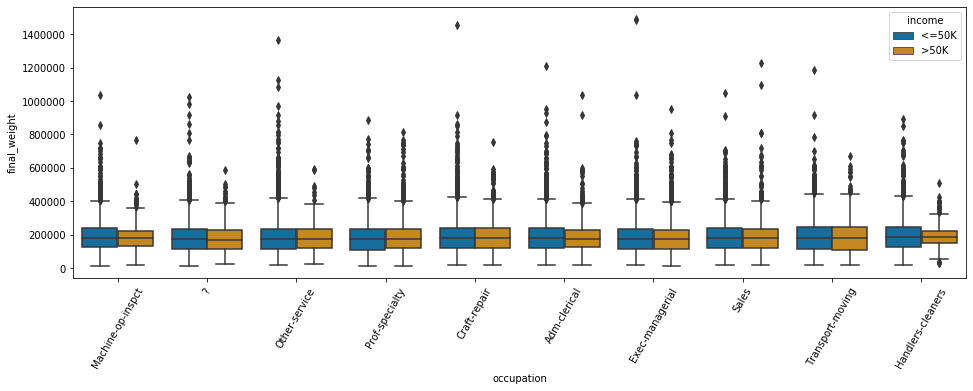

Box plot for **relationship** & **final_weight**

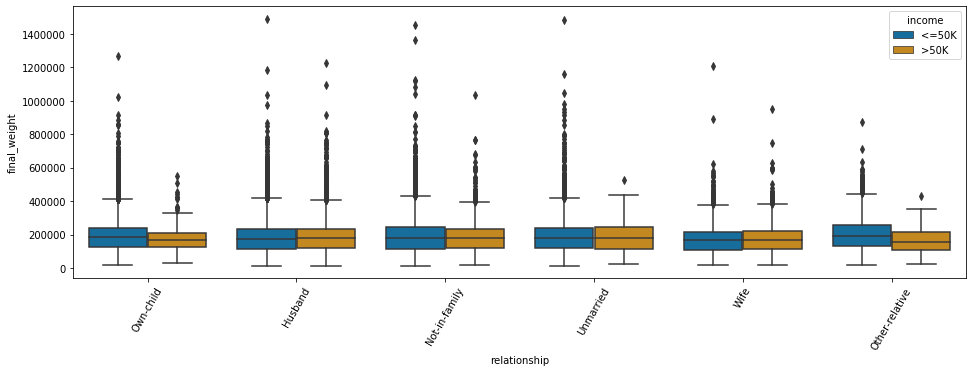

Box plot for **race** & **final_weight**

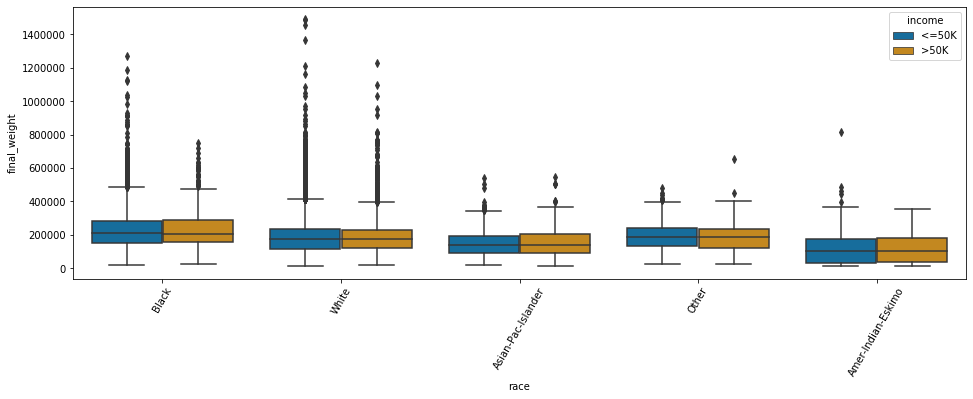

Box plot for **gender** & **final_weight**

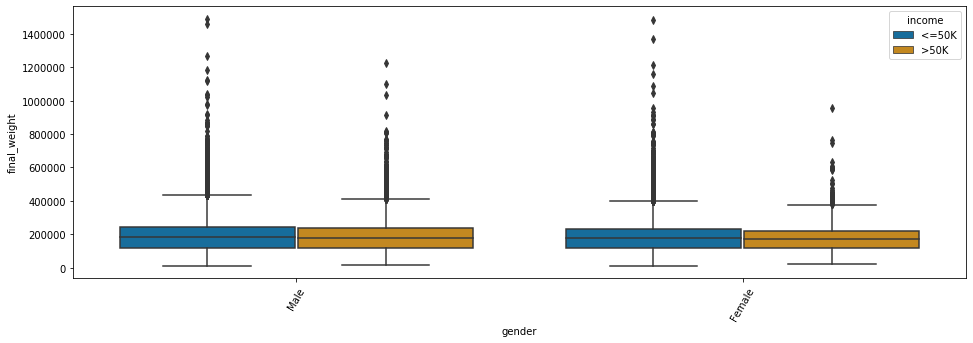

Box plot for **native-country** & **final_weight**

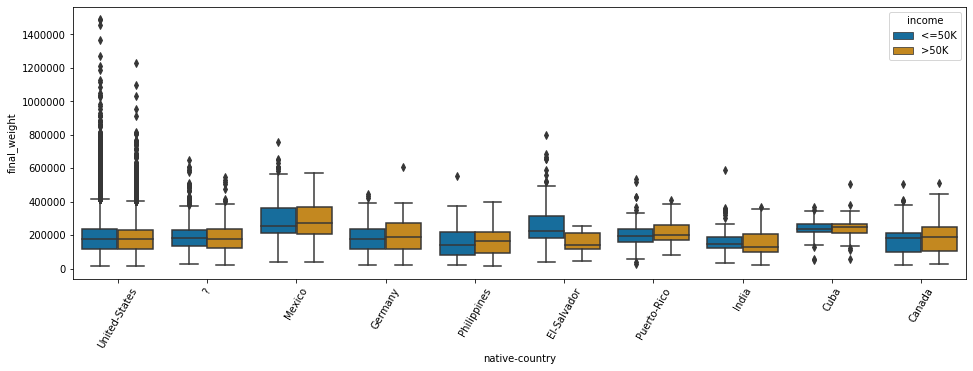

Box plot for **workclass** & **educational-num**

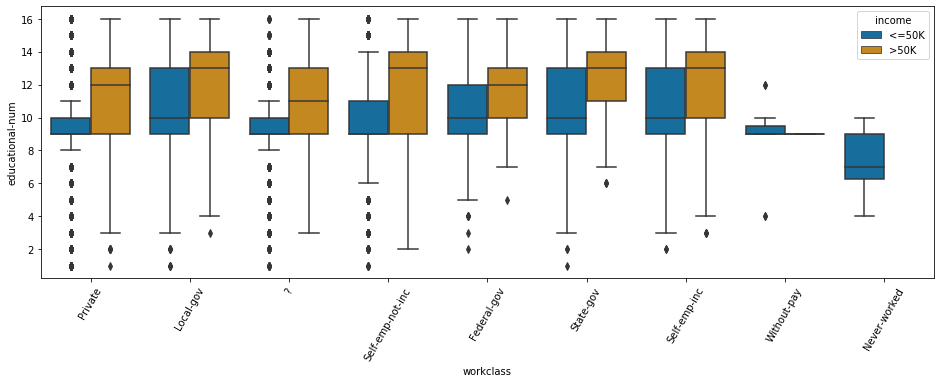

Box plot for **education** & **educational-num**

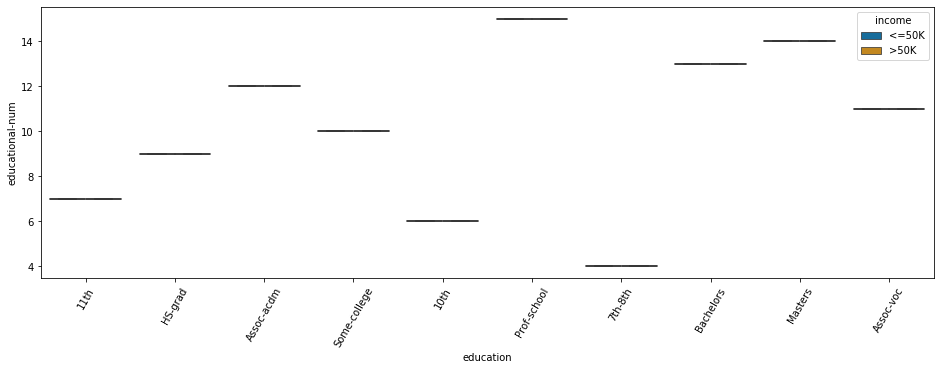

Box plot for **marital-status** & **educational-num**

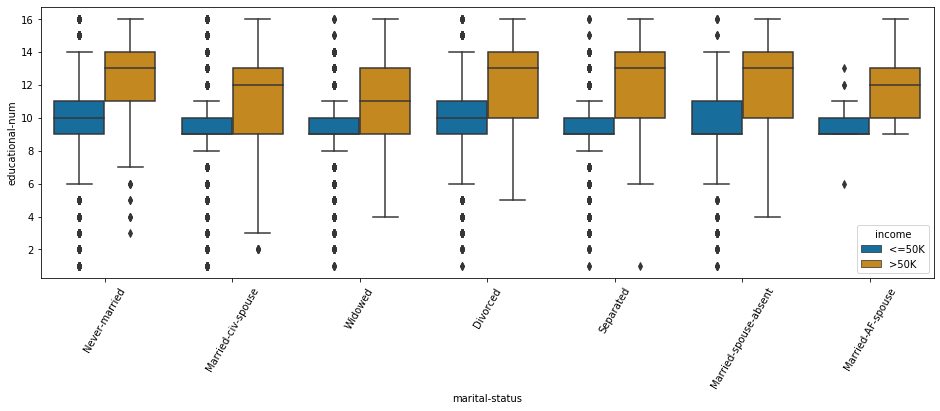

Box plot for **occupation** & **educational-num**

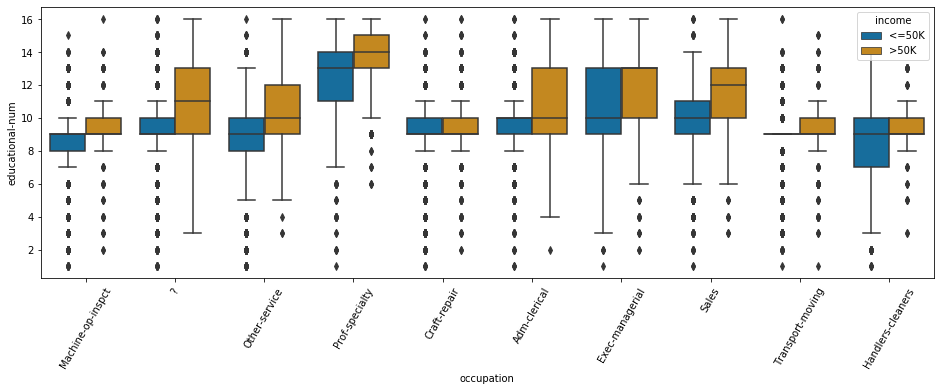

Box plot for **relationship** & **educational-num**

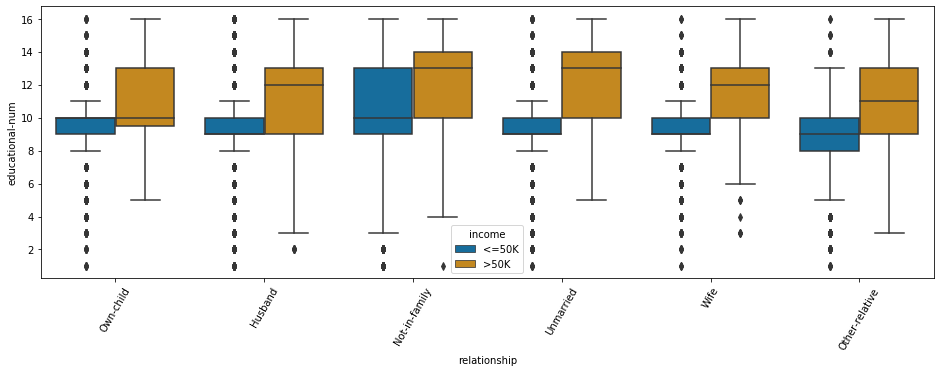

Box plot for **race** & **educational-num**

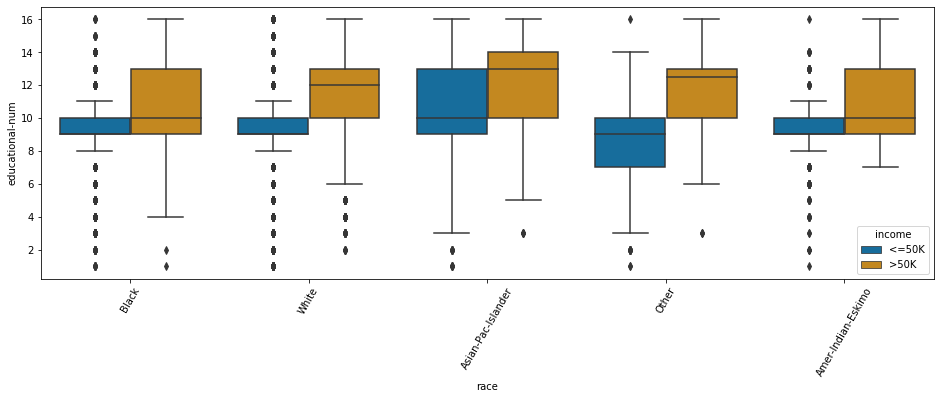

Box plot for **gender** & **educational-num**

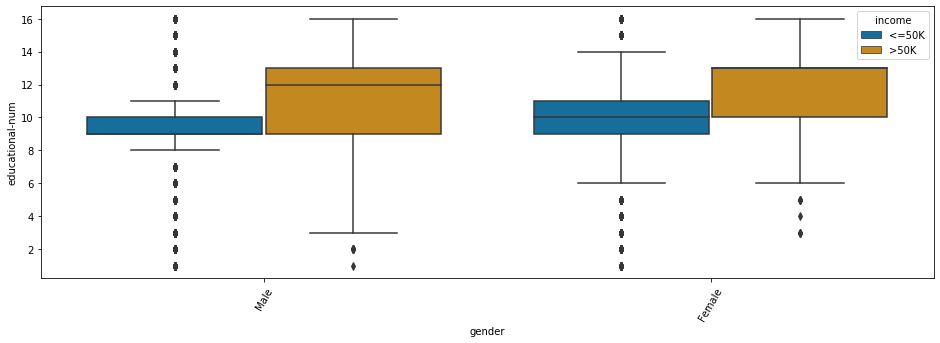

Box plot for **native-country** & **educational-num**

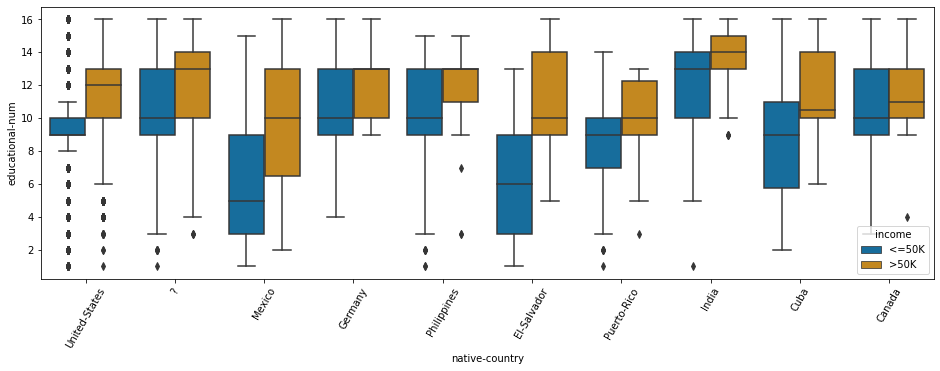

Box plot for **workclass** & **capital-gain**

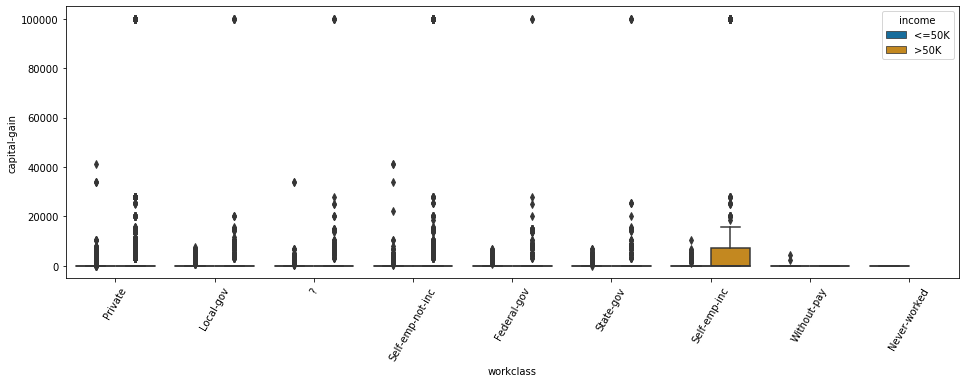

Box plot for **education** & **capital-gain**

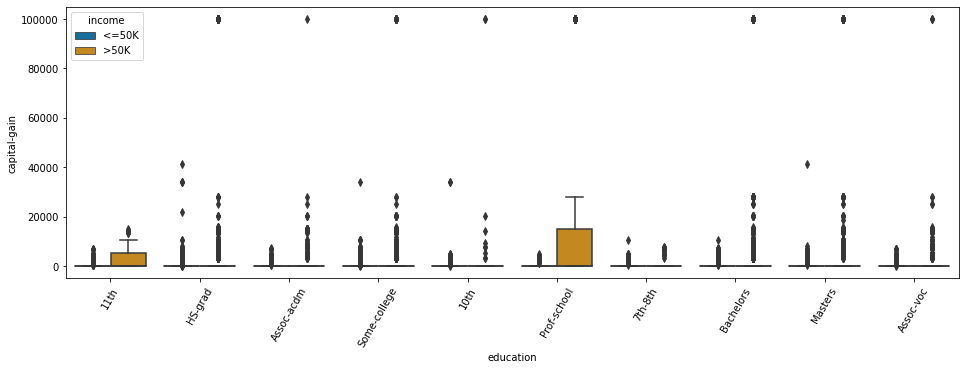

Box plot for **marital-status** & **capital-gain**

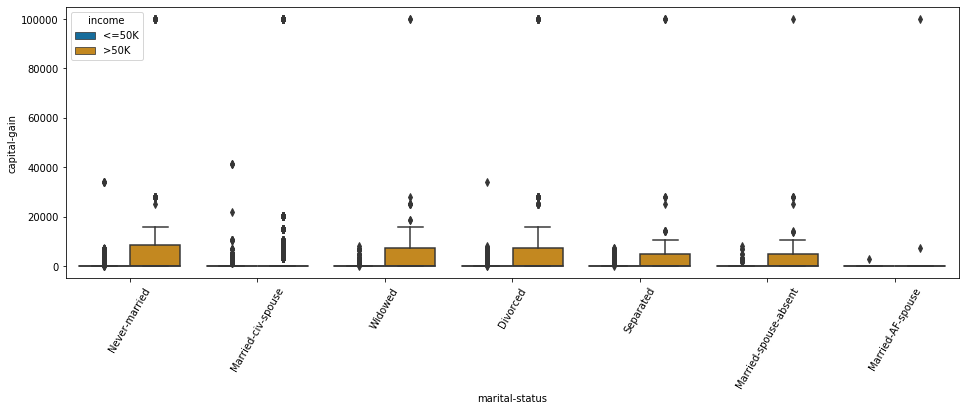

Box plot for **occupation** & **capital-gain**

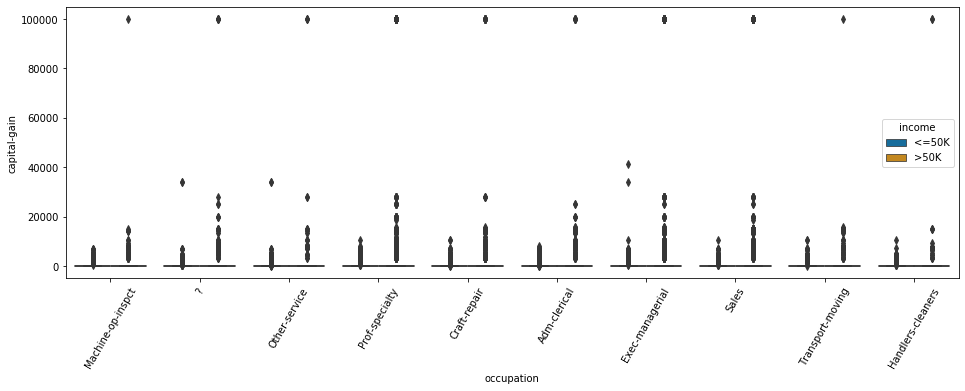

Box plot for **relationship** & **capital-gain**

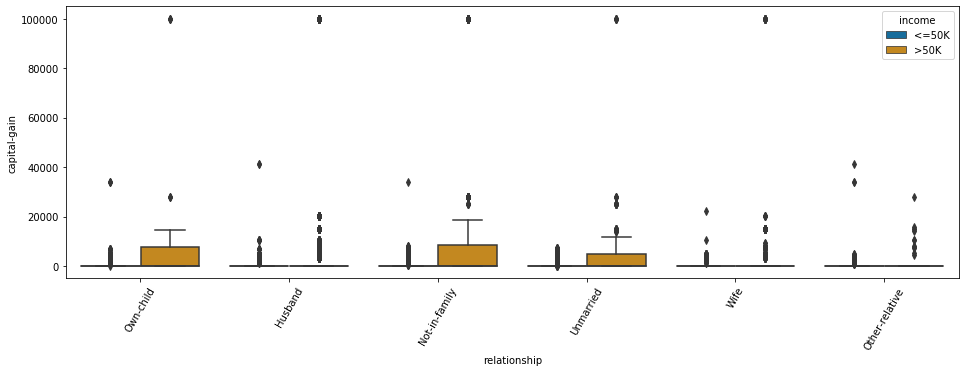

Box plot for **race** & **capital-gain**

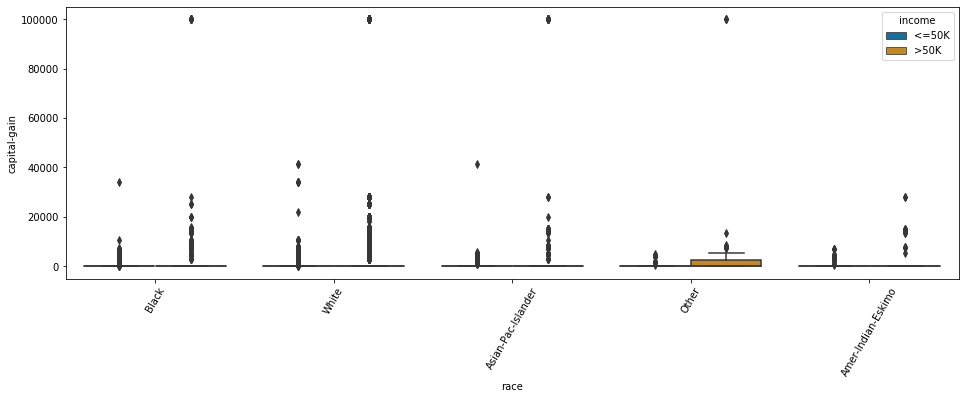

Box plot for **gender** & **capital-gain**

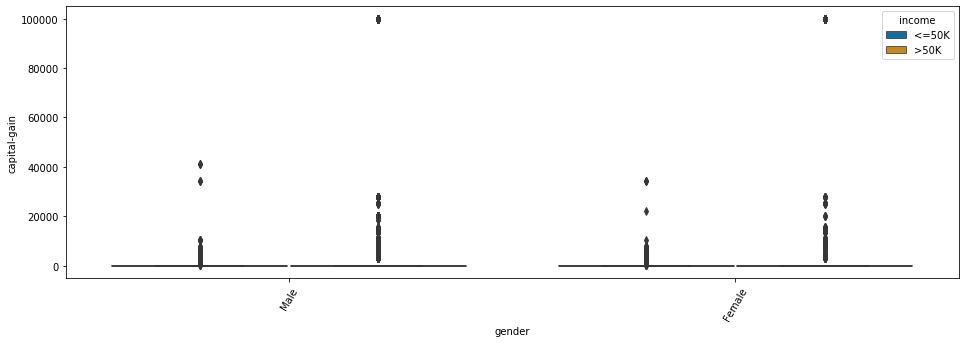

Box plot for **native-country** & **capital-gain**

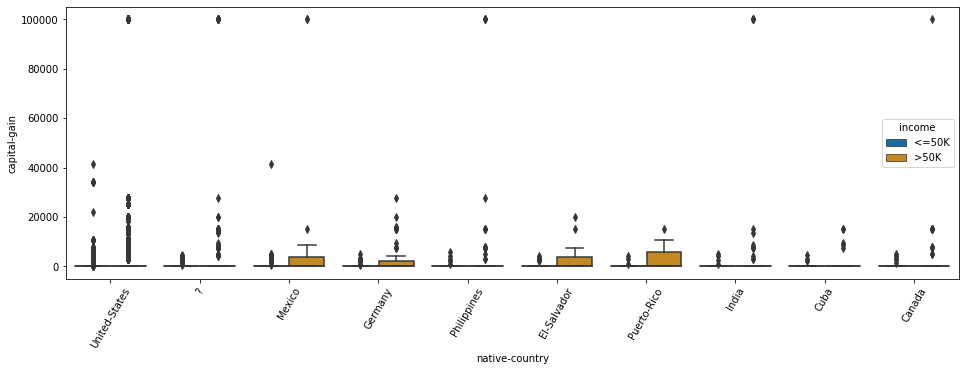

Box plot for **workclass** & **capital-loss**

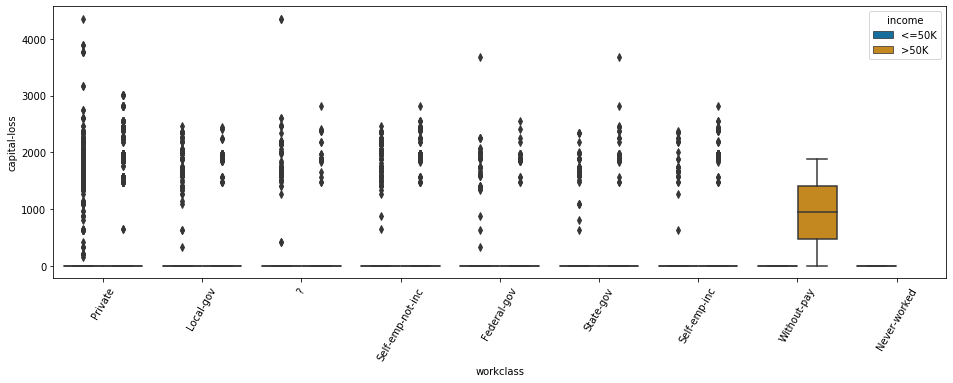

Box plot for **education** & **capital-loss**

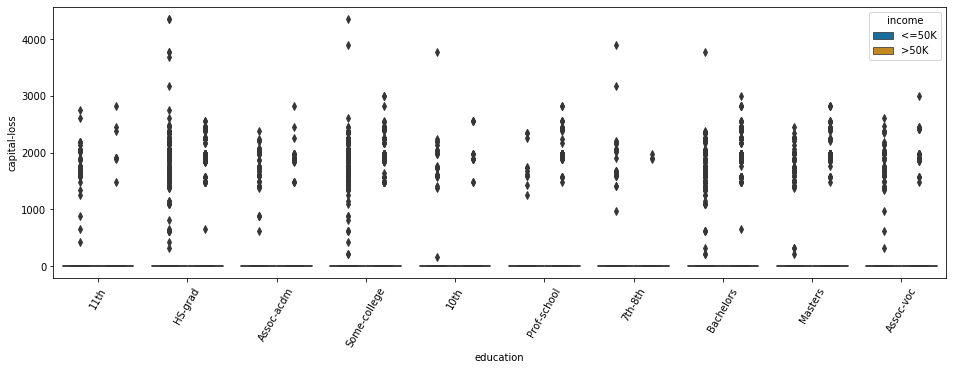

Box plot for **marital-status** & **capital-loss**

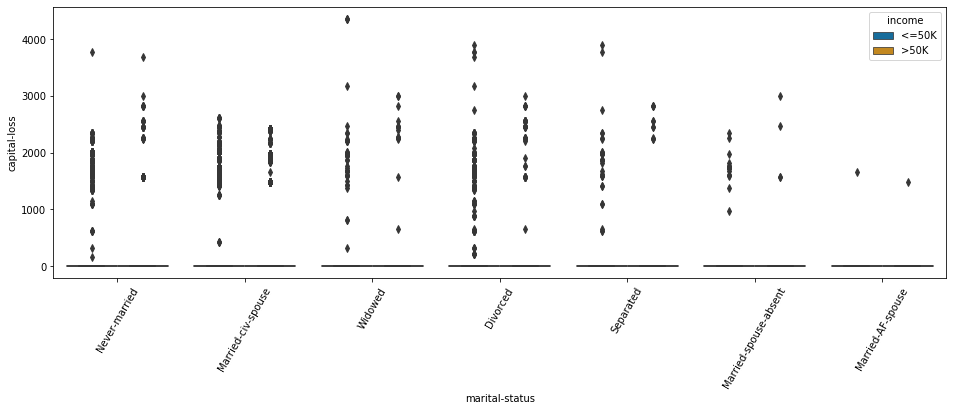

Box plot for **occupation** & **capital-loss**

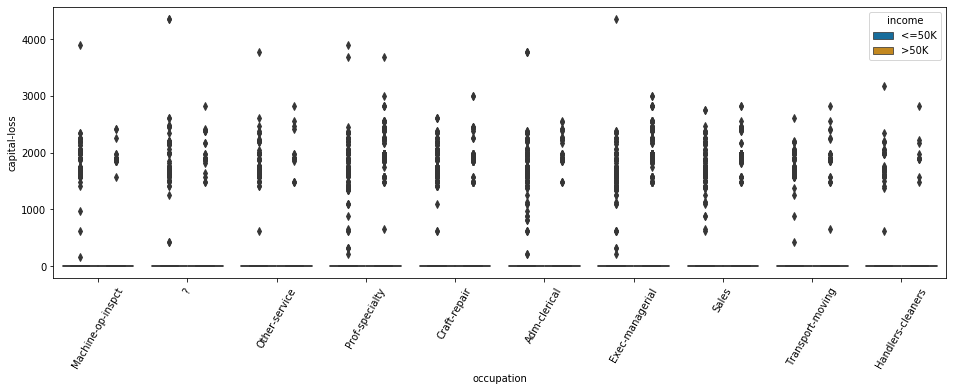

Box plot for **relationship** & **capital-loss**

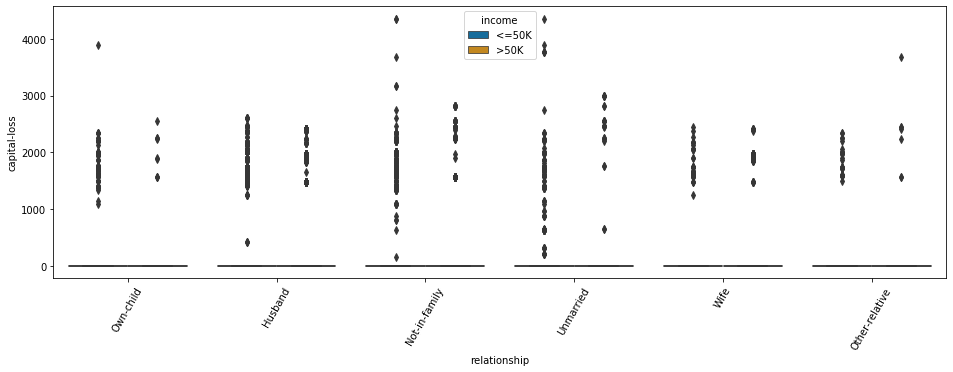

Box plot for **race** & **capital-loss**

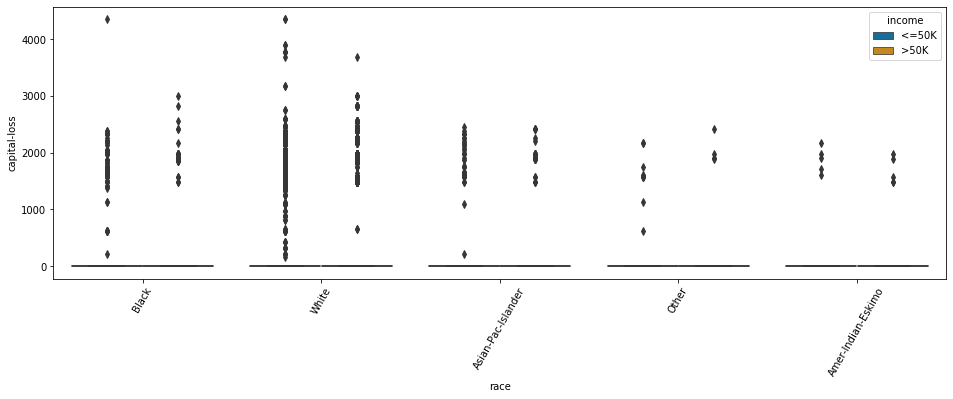

Box plot for **gender** & **capital-loss**

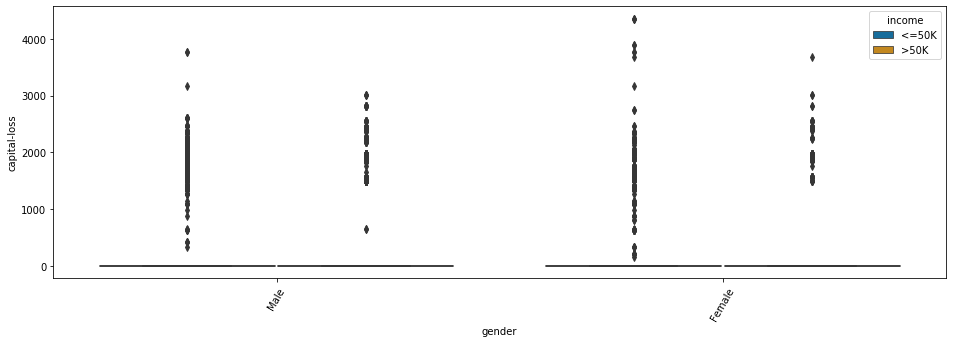

Box plot for **native-country** & **capital-loss**

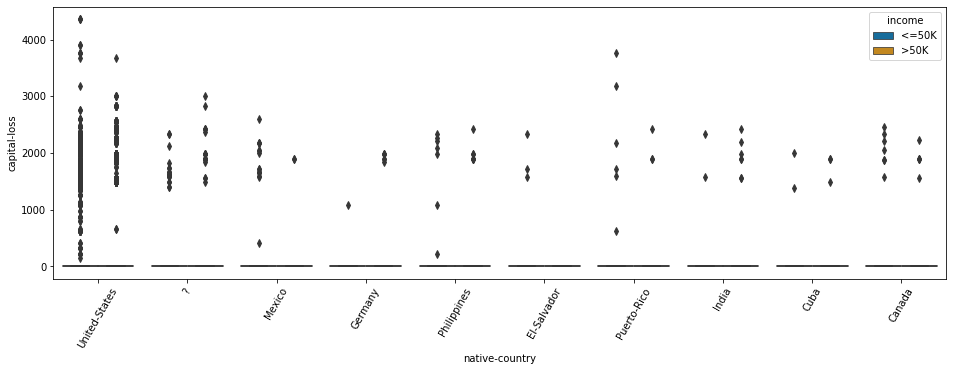

Box plot for **workclass** & **hours-per-week**

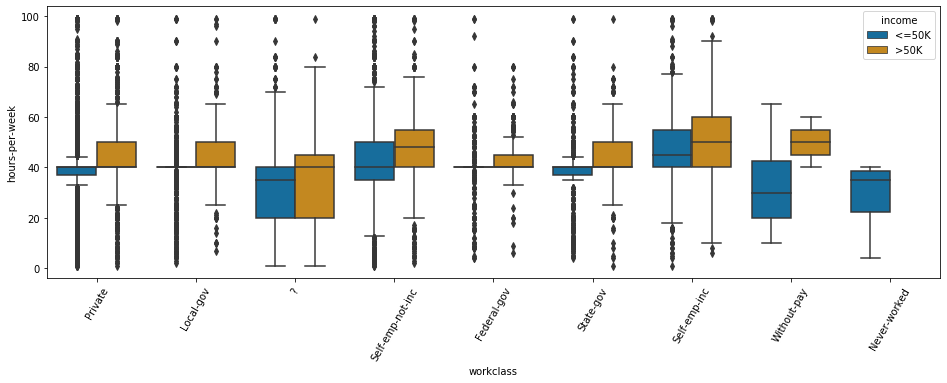

Box plot for **education** & **hours-per-week**

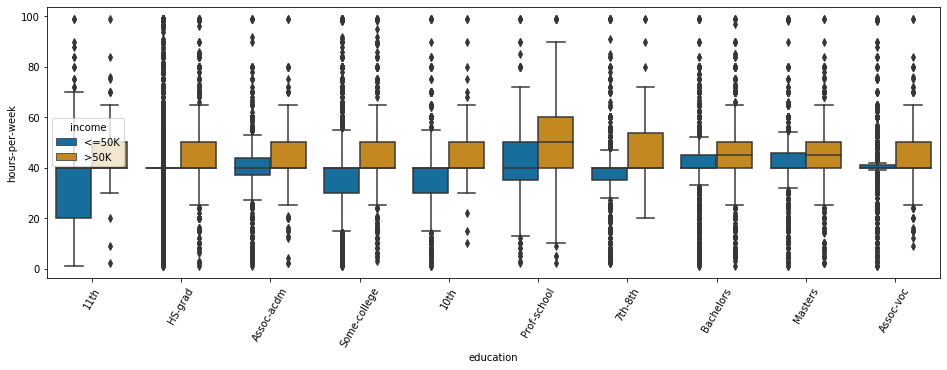

Box plot for **marital-status** & **hours-per-week**

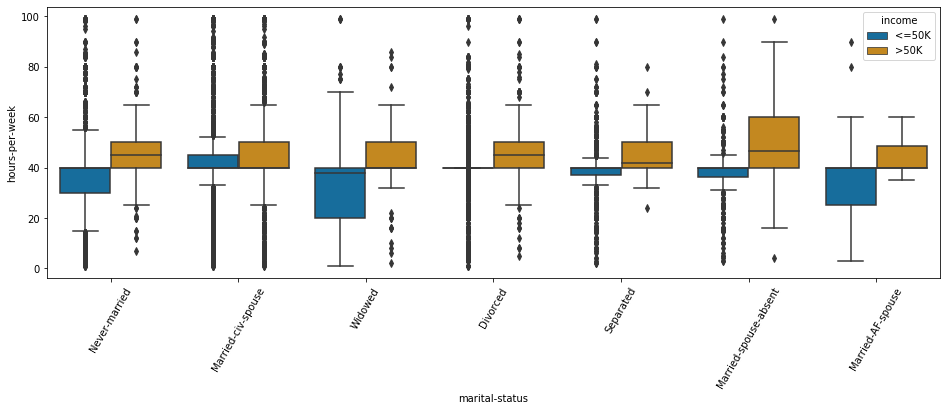

Box plot for **occupation** & **hours-per-week**

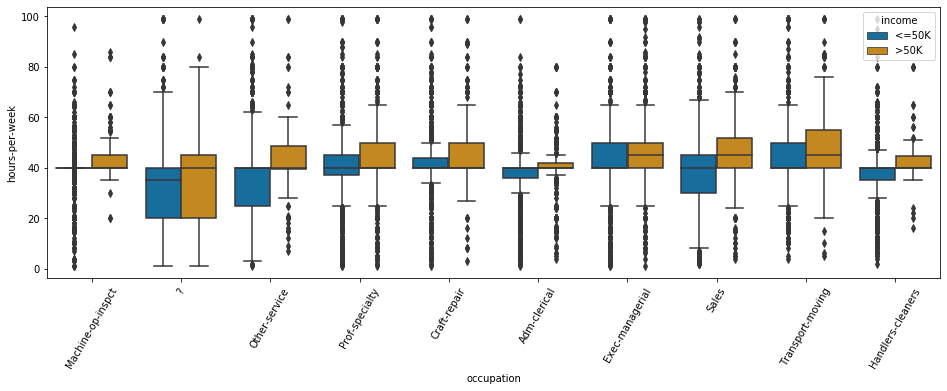

Box plot for **relationship** & **hours-per-week**

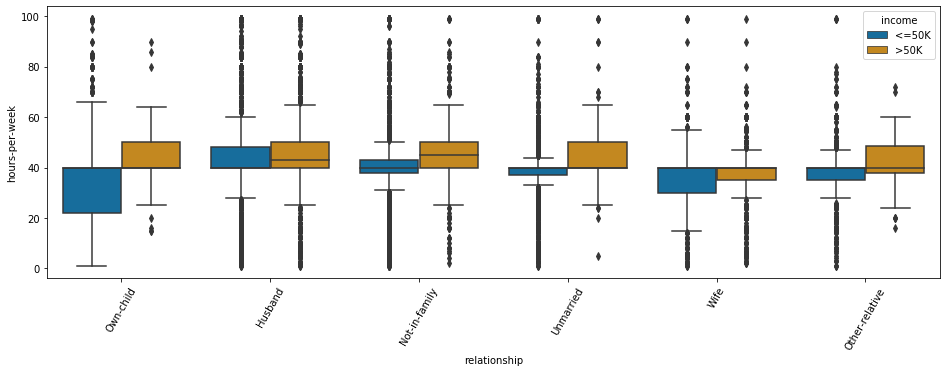

Box plot for **race** & **hours-per-week**

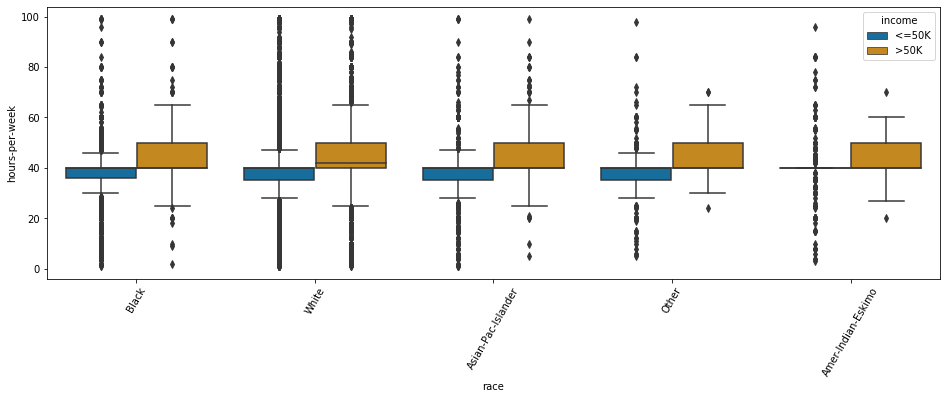

Box plot for **gender** & **hours-per-week**

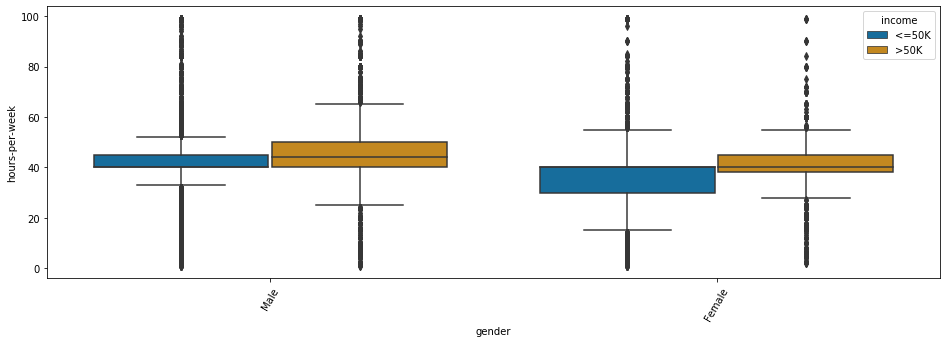

Box plot for **native-country** & **hours-per-week**

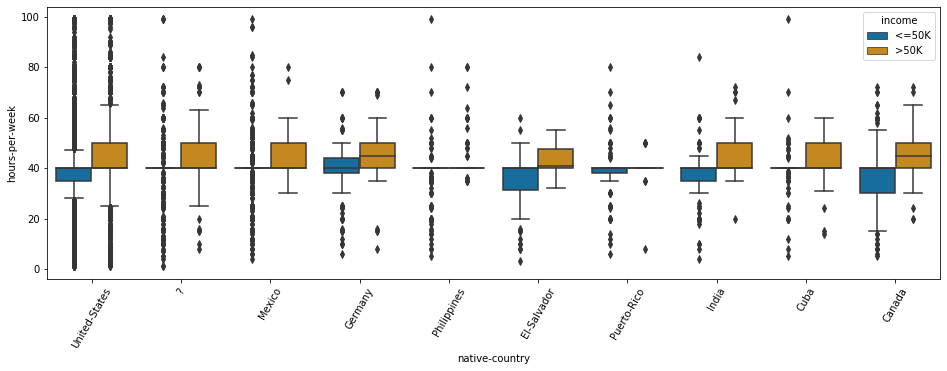

In [16]:
explore.show_df_num_cat_relations(df=adult, target='income')

In [17]:
help(explore.show_df_correlations)

Help on function show_df_correlations in module transparentai.explore.explore:

show_df_correlations(df)
    Show differents correlations matrix for 3 cases :
    - numerical to numerical (using Pearson coeff)
    - categorical to categorical (using Cramers V & Chi square)
    - numerical to categorical (discrete) (using Point Biserial)
    
    Parameters
    ----------
    df: pd.DataFrame
        Dataframe to inspect



#### Pearson correlation matrix for numerical variables

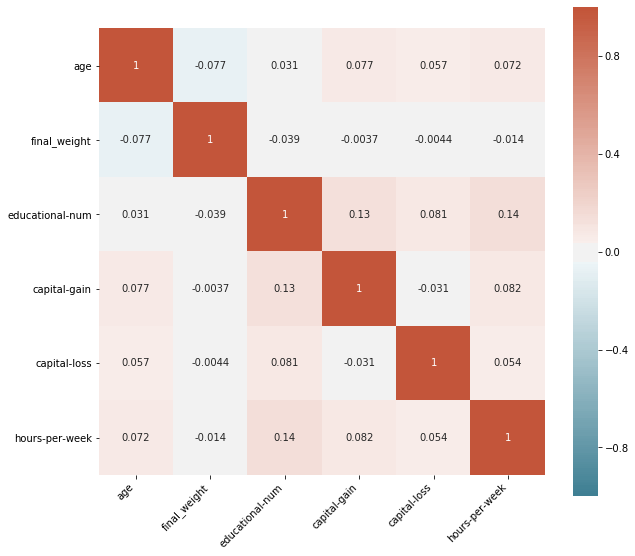

#### Cramers V correlation matrix for categorical variables

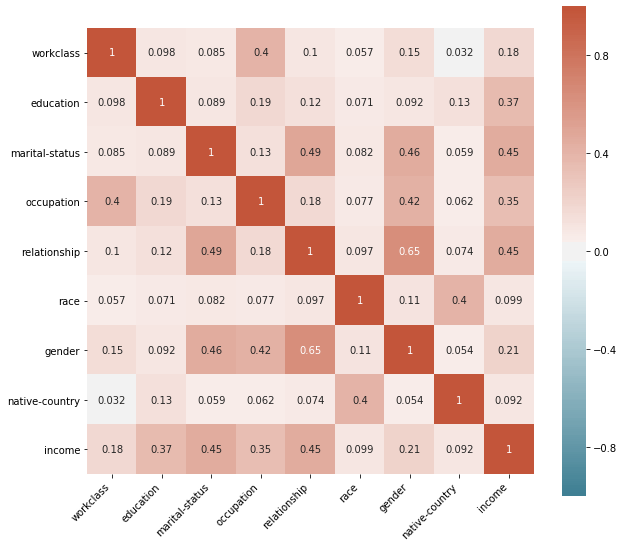

#### Point Biserial correlation matrix for numerical & categorical variables

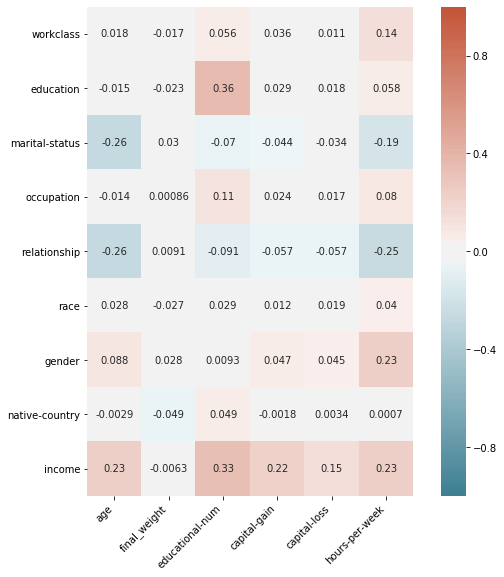

In [18]:
explore.show_df_correlations(df=adult)

## Handle dataset bias

Now let's take a look on dataset bias.

In [19]:
protected_vars = df_details[df_details['is_protected'] == 1]
protected_vars = np.where(protected_vars['new_name'].isna(), protected_vars['column'], protected_vars['new_name'])

for var in protected_vars:
    display(Markdown(f'#### {var}'))
    display(adult[var].unique())

#### age

array([25, 38, 28, 44, 18, 34, 29, 63, 24, 55, 65, 36, 26, 58, 48, 43, 20,
       37, 40, 72, 45, 22, 23, 54, 32, 46, 56, 17, 39, 52, 21, 42, 33, 30,
       47, 41, 19, 69, 50, 31, 59, 49, 51, 27, 57, 61, 64, 79, 73, 53, 77,
       80, 62, 35, 68, 66, 75, 60, 67, 71, 70, 90, 81, 74, 78, 82, 83, 85,
       76, 84, 89, 88, 87, 86])

#### marital-status

array(['Never-married', 'Married-civ-spouse', 'Widowed', 'Divorced',
       'Separated', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

#### race

array(['Black', 'White', 'Asian-Pac-Islander', 'Other',
       'Amer-Indian-Eskimo'], dtype=object)

#### gender

array(['Male', 'Female'], dtype=object)

#### native-country

array(['United-States', '?', 'Peru', 'Guatemala', 'Mexico',
       'Dominican-Republic', 'Ireland', 'Germany', 'Philippines',
       'Thailand', 'Haiti', 'El-Salvador', 'Puerto-Rico', 'Vietnam',
       'South', 'Columbia', 'Japan', 'India', 'Cambodia', 'Poland',
       'Laos', 'England', 'Cuba', 'Taiwan', 'Italy', 'Canada', 'Portugal',
       'China', 'Nicaragua', 'Honduras', 'Iran', 'Scotland', 'Jamaica',
       'Ecuador', 'Yugoslavia', 'Hungary', 'Hong', 'Greece',
       'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc)', 'France',
       'Holand-Netherlands'], dtype=object)

Convert age into a categorical variable for this purpose with the following rule : 
- if age < 26 then `Young`
- else if age < 61 then `Adult`
- else `Elder`

In [8]:
adult['age category'] = np.where(adult['age'] < 26, 'Young',
                                 np.where(adult['age'] < 61, 'Adult','Elder'))

## Using transparentai ClassificationDataset dataset

In [9]:
target = 'income'
privileged_values = {
    'age category': ['Adult'],
    'marital-status': ['Married-civ-spouse','Married-AF-spouse'],
    'race': ['White'],
    'gender': ['Male']
}
fair_dataset = ClassificationDataset(df=adult,
                                     label_name=target,
                                     privileged_values=privileged_values)

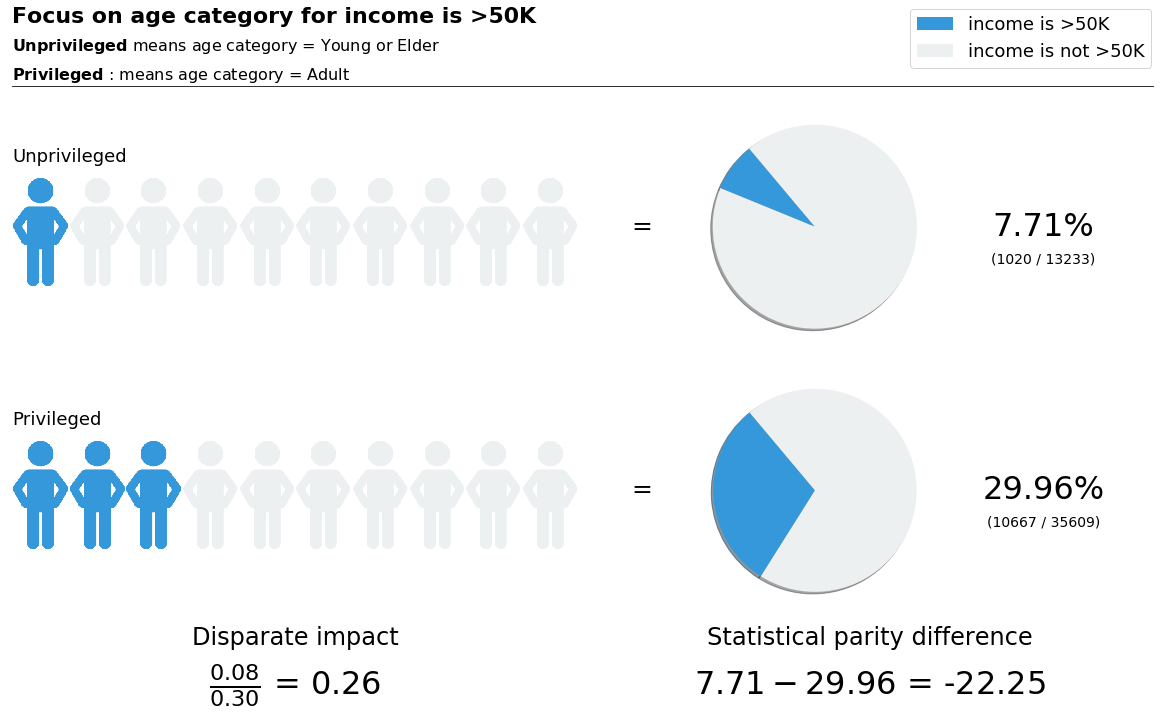

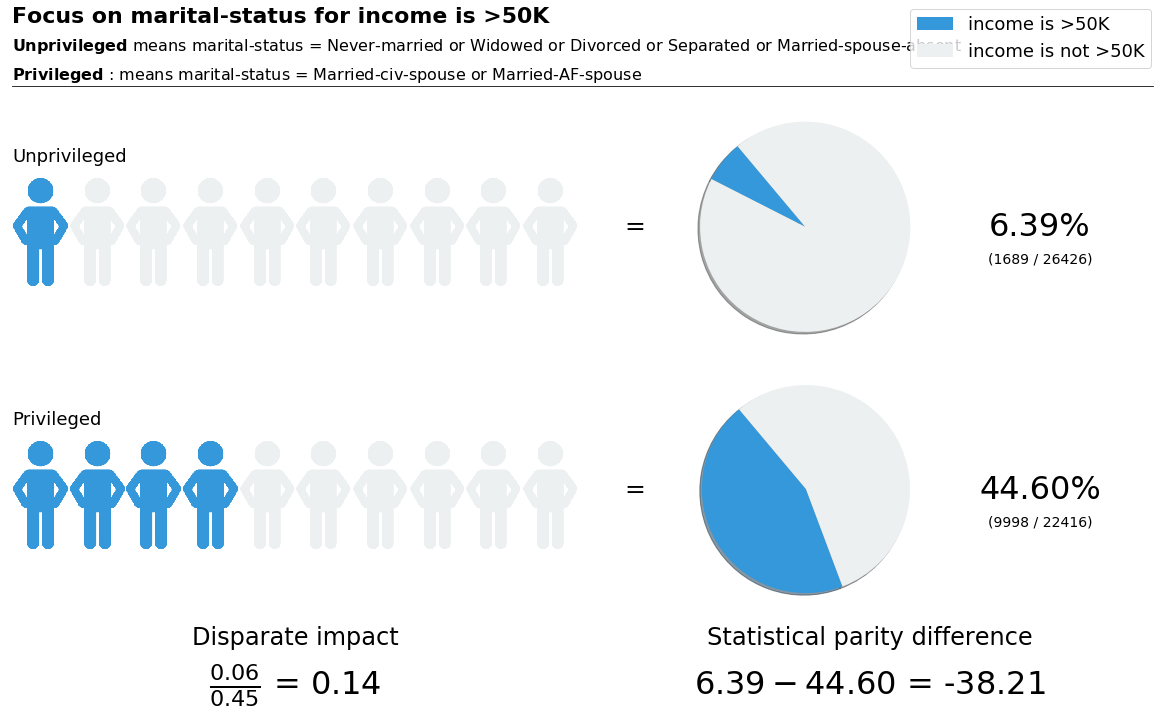

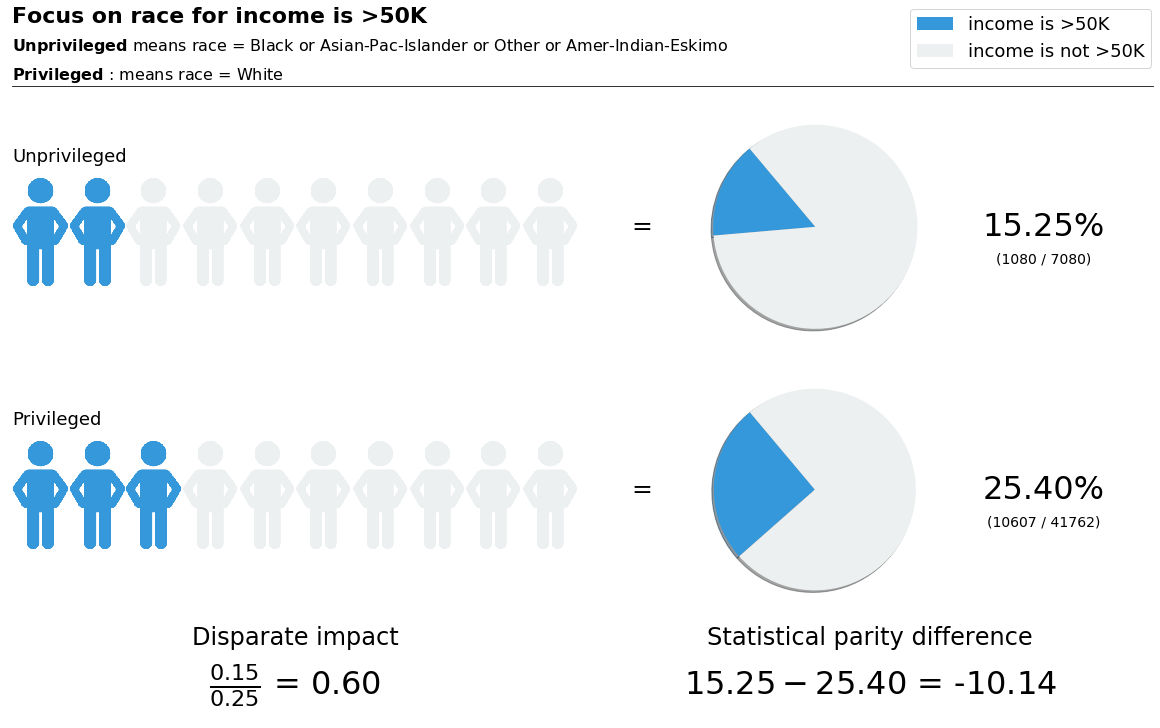

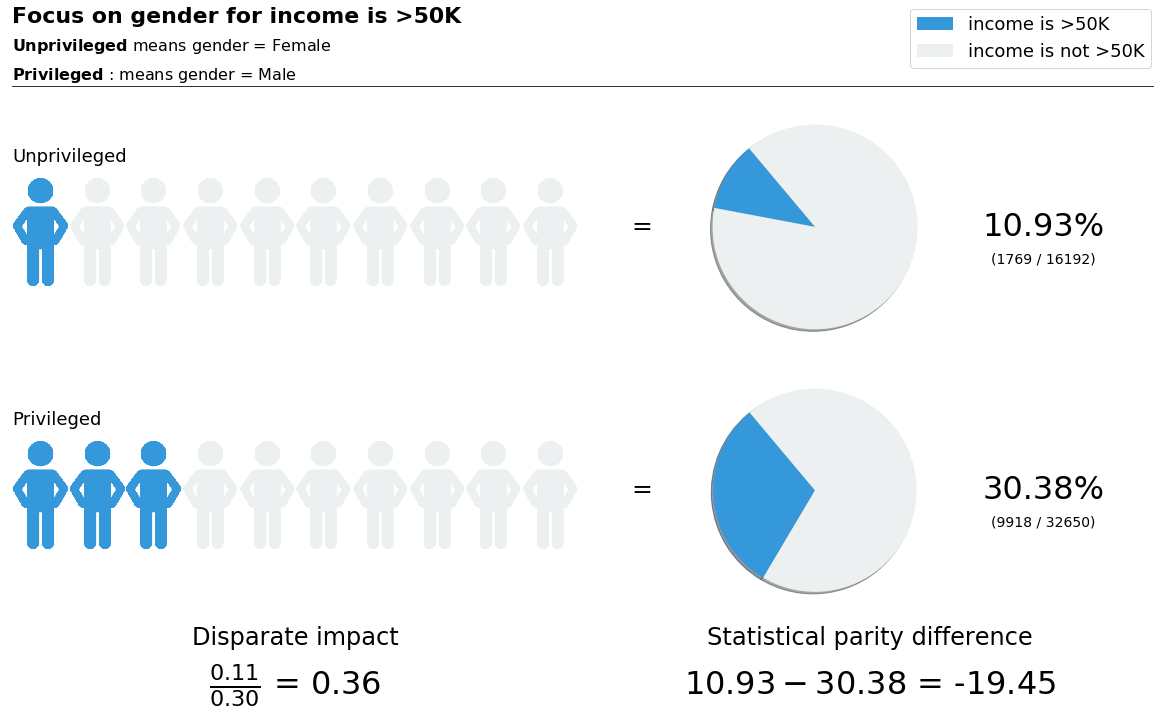

In [10]:
fair_dataset.show_bias_metrics(label_value='>50K')

## Insight from previous graphics

Now you have a lot of informations about your dataset ! You can go deeper by transform your data and re-execute a notebook with this template if necessary.

**Don't forget to detail your insight about this dataset on a worksheet or slides so that business people may understand what you found without going into this notebook by themselves** 

## The end.

Thanks for reading. *Nathan*